### Yolov5 object detection model

First lets get the bounding boxes for the LIDC images

Install utils to process dicom images, process the LIDC dataset, process the images and save them to files, and to download files from GCP stores

In [1]:
!pip install pydicom
!pip install pylidc
!pip install torchsummary
!pip install imageio
!pip install gsutil

     |████████████████████████████████| 2.0 MB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 60.7 MB/s eta 0:00:01
     |████████████████████████████████| 175 kB 85.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 85.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 80.4 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 77.0 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
     |████████████████████████████████| 2.9 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 74.6 MB/s eta 0:00:01
     |█████████████████

Install the util to sort the DICOM images

In [2]:
!git clone https://github.com/pieper/dicomsort.git

fatal: destination path 'dicomsort' already exists and is not an empty directory.


In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

Check if the util to process LIDC dataset is working properly

In [4]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787'

Install utils to query the Bigtables

In [5]:
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

     |████████████████████████████████| 203 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 198 kB 79.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 64.2 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
     |████████████████████████████████| 170 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.6 MB 73.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 59.8 MB/s eta 0:0

Load the magic to query bigtables from notebook

Might need one restart after the previous setep for the magic extension to load correctly

In [2]:
%load_ext google.cloud.bigquery

In [3]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=354066013909-il5lh54dbass54iv45m7thff0uuefjar.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=2OycvzaPCYoMvRQXBnbvKQkkgstyOP&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWgTYitatFpeFjc_OfnJsmEy1Oi6ntpHiRfQqhOh17KSnT38AkdIdkk


In [4]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

In [6]:
#myProjectID = "positive-sector-330514"
myProjectID = "idc-external-012"

In [7]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:01<00:00, 581.61rows/s]


In [8]:
total_patients = len(np.unique(CT_series['PatientID']))
chosen_patients = len(np.unique(CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]['PatientID']))
print("Choosing patients with slice thickness > 1.0")
print("Total patients is {} and chosen patients are {}".format(total_patients, chosen_patients))

Choosing patients with slice thickness > 1.0
Total patients is 1010 and chosen patients are 971


In [9]:
import pandas as pd
ct_series_HR = CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]
print("Shape of the raw dataset is {}".format(ct_series_HR.shape))

Shape of the raw dataset is (979, 5)


In [10]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [11]:
manifest_df.to_csv("gcs_paths_all.txt",header=False, index=False)
!head gcs_paths_all.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.324680252006411183918098592500/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

In [12]:
from tqdm import tqdm

In [13]:
from PIL import Image
import contextlib

def save_patient_images_and_masks(patient_id, root_dir='/app/data/yolov5'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        np.savez_compressed(image_file_name, image)
        np.savez_compressed(mask_file_name, mask)

In [14]:
root_dir = '/app/data/yolov5'
def patient_data_as_npz_files():
    #get patient list
    patient_list = os.listdir(data_folder)
    if not os.path.exists(root_dir):
        print("Creating directory {}".format(root_dir))
        os.makedirs(root_dir)
    if not os.path.exists(root_dir + "/images/"):
        print("Creating directory {}".format(root_dir + "/images/"))
        os.makedirs(root_dir + "/images/")
    if not os.path.exists(root_dir + "/masks/"):
        print("Creating directory {}".format(root_dir + "/masks/"))
        os.makedirs(root_dir + "/masks/")
    print("Saving patient .npz files to {}".format(root_dir))
    for i in tqdm(range(len(patient_list))):
        try:
            save_patient_images_and_masks(patient_list[i], root_dir)
        except:
            print("Error getting DICOM files for patient {}, skipping".format(patient_list[i]))

### Routine to download the DICOM images

Define the paths where we will download the DICOM images from GCP and then sort them.

We will clean up the download folder post download.

In [15]:
download_dir = '/app/data/yolov5/gcsfiles'
sorted_dir = '/app/data/yolov5/sorted_gcsfiles/'

In [16]:
!rm -rf {sorted_dir}

##### Routine to download and sort the DICOM images

Adjust how many we want to download, for now I will download 50 patients

In [17]:
%%time
import os, shutil
import glob

if not os.path.exists(download_dir):
    print("Creating directory {}".format(download_dir))
    os.makedirs(download_dir)
else:
    print("Directory {} exists".format(download_dir))

if not os.path.exists(sorted_dir):
    print("Creating directory {}".format(sorted_dir))
    os.makedirs(sorted_dir)
else:
    print("Directory {} exists".format(sorted_dir))

for i in tqdm(range(manifest_df.shape[0])):
    url = manifest_df.iloc[i].gcs
    download_command = "gsutil -u {} -m cp -r {} {} >/dev/null 2>&1".format(myProjectID, url, download_dir)
    os.system(download_command)
    if (i > 1) and (i % 50 == 0): # got 50 patients
        # sort the images
        sort_command = "python dicomsort/dicomsort.py -u {} {}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm".format(download_dir, sorted_dir)
        os.system(sort_command)
        print("Cleaning up downloaded DICOM files...")
        files = glob.glob(download_dir + "/*")
        for j in tqdm(range(len(files))):
            if os.path.isdir(files[j]):
                shutil.rmtree(files[j])
        print("Saved {} patients data. Quitting!".format(i))
        break

Creating directory /app/data/yolov5/gcsfiles
Creating directory /app/data/yolov5/sorted_gcsfiles/


100%|██████████| 8826/8826 [00:16<00:00, 532.79it/s]                                                                          | 50/979 [02:56<50:00,  3.23s/it]


Files sorted
Cleaning up downloaded DICOM files...



  5%|██████                                                                                                                 | 50/979 [03:16<1:00:51,  3.93s/it]

Saved 50 patients data. Quitting!
CPU times: user 233 ms, sys: 732 ms, total: 965 ms
Wall time: 3min 16s


Configure the pylidc file so that we can query the download LIDC dataset

In [18]:
import os
# this directory will be created in the downloader but never deleted entirely, only contents would be cleared
data_folder = sorted_dir

In [19]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [20]:
import os
patient_list = os.listdir(data_folder)

In [21]:
patient_list[:5]

['LIDC-IDRI-0047',
 'LIDC-IDRI-0033',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0049',
 'LIDC-IDRI-0025']

In [22]:
from PIL import Image

In [23]:
def load_vol_for_patient(patient_id):
    patient_id = [patient_id]
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()
    return vol, nodules_annotation

In [24]:
pat_id = 'LIDC-IDRI-0001'
vol, nodules_annotation = load_vol_for_patient(pat_id)
print("There are {} nodules annotated for the patient {}".format(len(nodules_annotation), pat_id))

There are 1 nodules annotated for the patient LIDC-IDRI-0001


Define some routines to get the bounding around for the masks for the image

In [25]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
    if len(minx) > 0:
        x,y,w,h = np.min(minx), np.min(miny), np.max(maxx) - np.min(minx), np.max(maxy)-np.min(miny)
        return x,y,w,h
    else:
        return None,None,None,None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    x,y,w,h = get_bounding_box(img)
    if x is not None:
        print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

Routine to find all bounding boxes for the mask and plotting

In [26]:
def find_all_bboxes(nodule_annotation, plot=False):
    bboxes = []
    cmask, cbbox, masks = consensus(nodule_annotation)
    print("There are {} slices in the image".format(cbbox[2].stop - cbbox[2].start))
    for idx in range(cbbox[2].stop - cbbox[2].start):
        x,y,w,h = get_bounding_box(cmask[:,:,idx])
        if plot:
            plot_bounding_box(cmask[:,:,idx])
        bboxes.append([x,y,w,h])
    return bboxes

There are 9 slices in the image
x = 7.5, y = 17.5, w = 23.0, h= 17.0
x = 3.5, y = 9.5, w = 30.0, h= 36.0
x = 1.5, y = 7.5, w = 36.0, h= 38.0
x = 1.5, y = 2.5, w = 36.0, h= 42.0
x = 3.5, y = 7.5, w = 35.0, h= 40.0
x = 4.5, y = 10.5, w = 33.0, h= 32.0
x = 5.5, y = 14.5, w = 32.0, h= 26.0
x = 6.5, y = 14.5, w = 24.0, h= 26.0


[[7.5, 17.5, 23.0, 17.0],
 [3.5, 9.5, 30.0, 36.0],
 [1.5, 7.5, 36.0, 38.0],
 [1.5, 2.5, 36.0, 42.0],
 [3.5, 7.5, 35.0, 40.0],
 [4.5, 10.5, 33.0, 32.0],
 [5.5, 14.5, 32.0, 26.0],
 [6.5, 14.5, 24.0, 26.0],
 [None, None, None, None]]

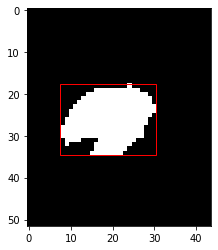

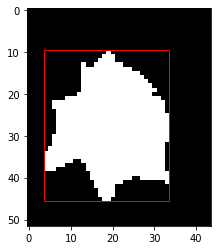

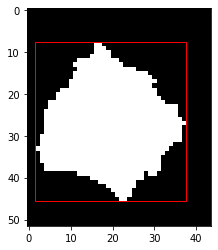

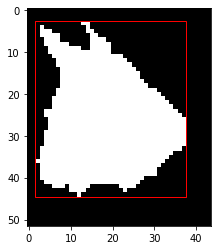

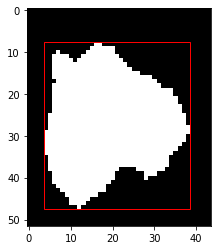

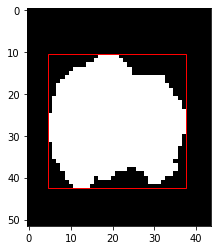

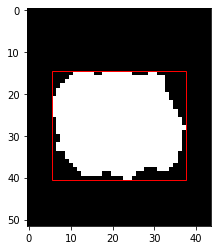

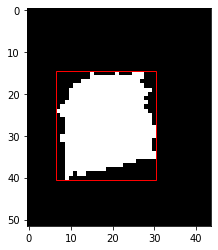

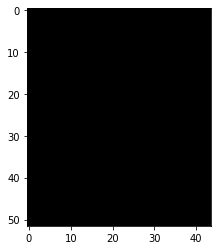

In [27]:
find_all_bboxes(nodules_annotation[0], plot=True)

Routine to plot the bounding box around the mask in the full size mask

In [28]:
def plot_bbox_on_full_size_mask(vol, nodules_annotation):
    CT_mask = np.zeros_like(vol)
    cmask, cbbox, masks = consensus(nodules_annotation)
    CT_mask[cbbox] += cmask
    for slice_idx in np.arange(cbbox[2].start, cbbox[2].stop):
        plot_bounding_box(CT_mask[:,:,slice_idx])

x = 304.5, y = 357.5, w = 23.0, h= 17.0
x = 300.5, y = 349.5, w = 30.0, h= 36.0
x = 298.5, y = 347.5, w = 36.0, h= 38.0
x = 298.5, y = 342.5, w = 36.0, h= 42.0
x = 300.5, y = 347.5, w = 35.0, h= 40.0
x = 301.5, y = 350.5, w = 33.0, h= 32.0
x = 302.5, y = 354.5, w = 32.0, h= 26.0
x = 303.5, y = 354.5, w = 24.0, h= 26.0


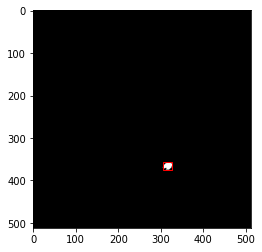

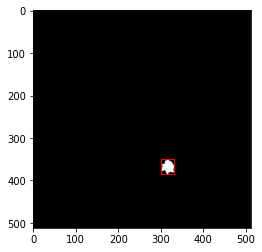

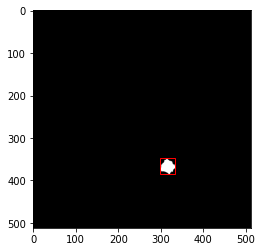

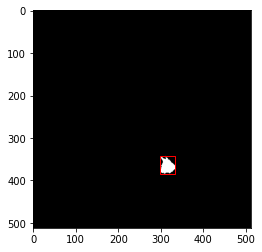

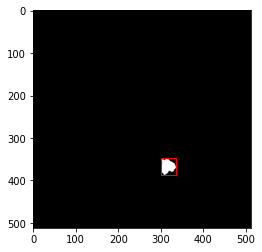

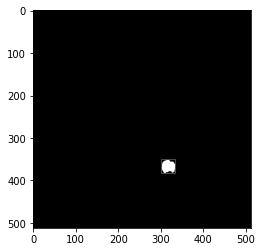

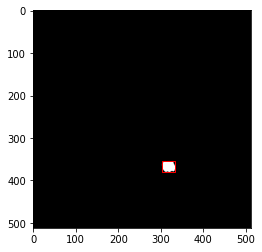

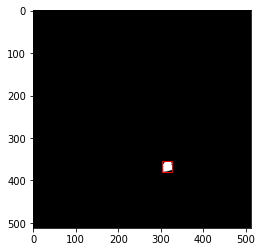

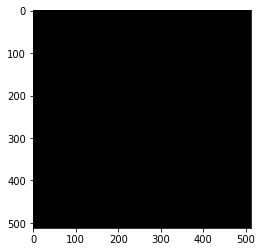

In [29]:
plot_bbox_on_full_size_mask(vol, nodules_annotation[0])

Routine to plot the bounding box around the nodule using the mask bounding box coordinates

In [30]:
def plot_bbox_on_image(vol, nodules_annotation):
    CT_mask = np.zeros_like(vol)
    cmask, cbbox, masks = consensus(nodules_annotation)
    CT_mask[cbbox] += cmask
    for slice_idx in np.arange(cbbox[2].start, cbbox[2].stop):
        x,y,w,h = get_bounding_box(CT_mask[:,:,slice_idx])
        img = vol[:,:,slice_idx]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=plt.cm.gray)
        if x is not None:
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

x = 304.5, y = 357.5, w = 23.0, h= 17.0
x = 300.5, y = 349.5, w = 30.0, h= 36.0
x = 298.5, y = 347.5, w = 36.0, h= 38.0
x = 298.5, y = 342.5, w = 36.0, h= 42.0
x = 300.5, y = 347.5, w = 35.0, h= 40.0
x = 301.5, y = 350.5, w = 33.0, h= 32.0
x = 302.5, y = 354.5, w = 32.0, h= 26.0
x = 303.5, y = 354.5, w = 24.0, h= 26.0


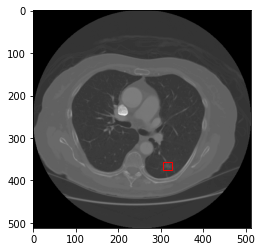

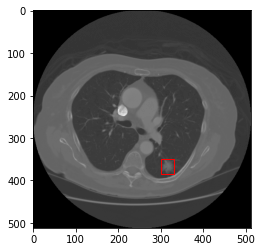

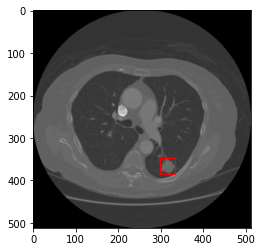

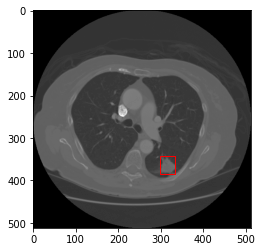

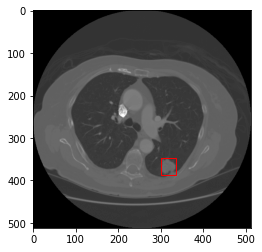

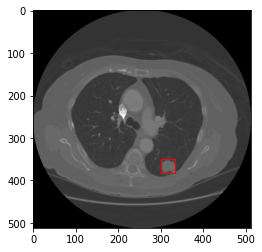

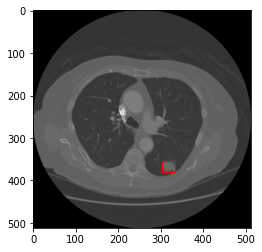

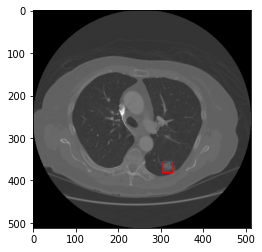

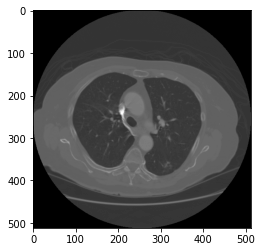

In [31]:
plot_bbox_on_image(vol, nodules_annotation[0])

### Prepare the dataset for YoloV5 training

Routine to create the image and the labels (based on bounding boxes) for Yolov5 training

In [32]:
image_path = '/app/data/yolov5/train/images'
label_path = '/app/data/yolov5/train/labels'

In [33]:
!mkdir -p {image_path}
!mkdir -p {label_path}

##### Clear the contents of the generated images and labels for Yolov5

In [203]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [204]:
clear_dirs([image_path, label_path])

In [57]:
import os
import contextlib
import imageio
patient_list = os.listdir(data_folder)


def save_image_and_label(patient_id):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
        for k_slice in np.arange(cbbox[2].start, cbbox[2].stop):
            im = vol[:,:,k_slice]    
            msk = CT_mask[:,:,k_slice]
            x,y,w,h = get_bounding_box(msk)    
            if x is not None:
                image_filename = "{}_{}_{}.jpg".format(patient_id, i, k_slice)
                print("Saving image to file {}".format(image_path + "/" + image_filename))
                imageio.imwrite(image_path + "/" + image_filename, im)
                
                center_x = (x + ((w)/2))/vol[:,:,k_slice].shape[0]
                center_y = (y + ((h)/2))/vol[:,:,k_slice].shape[1]
                width = w/vol[:,:,k_slice].shape[0]
                height = h/vol[:,:,k_slice].shape[1]
                
                c = 0 #there is only one class, the 'nodule'
                #save this as the label for the image for the YoloV5 object detection training
                print("Yolov5 formatted labels are = {} {} {} {} {}".format(c, center_x, center_y, width, height))
                label = "{} {} {} {} {}".format(c, center_x, center_y, width, height)
                label_filename = "{}_{}_{}.txt".format(patient_id, i, k_slice)

                f = open(label_path + "/" + label_filename, "a")
                f.write(label)
                f.close()

##### For all the patients we downloaded, extract the bounding box and create the image and labels for YoloV5 training

In [58]:
%time
for patient in patient_list:
    if not os.path.exists(image_path):
        print("Creating directory {}".format(image_path))
        os.makedirs(image_path)
    if not os.path.exists(label_path):
        print("Creating directory {}".format(label_path))
        os.makedirs(label_path)
    save_image_and_label(patient)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


Lossy conversion from int16 to uint8. Range [-2048, 1466]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1428]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1201]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0047 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0047_0_75.jpg
Yolov5 formatted labels are = 0 0.2783203125 0.5576171875 0.0390625 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0047_0_76.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.5517578125 0.0390625 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0047_0_77.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.5517578125 0.03515625 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0047_0_78.jpg
Yolov5 formatted labels are = 0 0.2744140625 0.556640625 0.03125 0.025390625


Lossy conversion from int16 to uint8. Range [-2048, 1872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1996]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2045]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1956]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1878]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0033 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_0_105.jpg
Yolov5 formatted labels are = 0 0.748046875 0.626953125 0.021484375 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_0_106.jpg
Yolov5 formatted labels are = 0 0.7470703125 0.6279296875 0.01953125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_0_107.jpg
Yolov5 formatted labels are = 0 0.7490234375 0.6298828125 0.015625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_1_107.jpg
Yolov5 formatted labels are = 0 0.6396484375 0.638671875 0.234375 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_1_108.jpg
Yolov5 formatted labels are = 0 0.5400390625 0.6474609375 0.03515625 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0033_1_109.jpg
Yolov5 formatted labels are = 0 0.55078125 0.6533203125 0.021484375 0.0234375
Saving image to file 

Lossy conversion from int16 to uint8. Range [-2048, 1475]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1667]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1687]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1860]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1952]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1806]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1460]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0006 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_0_54.jpg
Yolov5 formatted labels are = 0 0.373046875 0.666015625 0.017578125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_0_55.jpg
Yolov5 formatted labels are = 0 0.373046875 0.6650390625 0.017578125 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_1_68.jpg
Yolov5 formatted labels are = 0 0.7646484375 0.650390625 0.015625 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_2_69.jpg
Yolov5 formatted labels are = 0 0.703125 0.6845703125 0.013671875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_2_70.jpg
Yolov5 formatted labels are = 0 0.7119140625 0.6884765625 0.0390625 0.03515625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_2_71.jpg
Yolov5 formatted labels are = 0 0.712890625 0.6962890625 0.037109375 0.01953125
Saving image to file /app/da

Lossy conversion from int16 to uint8. Range [-2048, 1369]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1346]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1333]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1277]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1132]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1445]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1253]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0049 is 15
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_0_35.jpg
Yolov5 formatted labels are = 0 0.234375 0.6875 0.005859375 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_0_36.jpg
Yolov5 formatted labels are = 0 0.23828125 0.6796875 0.013671875 0.021484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_0_37.jpg
Yolov5 formatted labels are = 0 0.23828125 0.6767578125 0.021484375 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_0_38.jpg
Yolov5 formatted labels are = 0 0.240234375 0.669921875 0.025390625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_1_51.jpg
Yolov5 formatted labels are = 0 0.6904296875 0.2734375 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_1_52.jpg
Yolov5 formatted labels are = 0 0.69140625 0.2763671875 0.013671875 0.015625
Saving image to file /app/data/yolov5

Lossy conversion from int16 to uint8. Range [-2048, 1510]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1924]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1924]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2714]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_3_61.jpg
Yolov5 formatted labels are = 0 0.728515625 0.3896484375 0.220703125 0.296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_4_63.jpg
Yolov5 formatted labels are = 0 0.70703125 0.2841796875 0.009765625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_4_64.jpg
Yolov5 formatted labels are = 0 0.70703125 0.2841796875 0.017578125 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_5_65.jpg
Yolov5 formatted labels are = 0 0.63671875 0.705078125 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_5_66.jpg
Yolov5 formatted labels are = 0 0.63671875 0.7080078125 0.017578125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_6_64.jpg
Yolov5 formatted labels are = 0 0.4873046875 0.3486328125 0.45703125 0.140625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_6_65.jpg
Yolov5

Lossy conversion from int16 to uint8. Range [-2048, 2283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2701]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2701]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2629]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.4638671875 0.5693359375 0.42578125 0.3125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_7_68.jpg
Yolov5 formatted labels are = 0 0.271484375 0.4296875 0.025390625 0.021484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_8_66.jpg
Yolov5 formatted labels are = 0 0.4501953125 0.56640625 0.453125 0.318359375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_8_67.jpg
Yolov5 formatted labels are = 0 0.44921875 0.5693359375 0.455078125 0.3125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_8_68.jpg
Yolov5 formatted labels are = 0 0.2548828125 0.4326171875 0.05859375 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_9_67.jpg
Yolov5 formatted labels are = 0 0.44921875 0.5703125 0.455078125 0.314453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_9_68.jpg
Yolov5 formatted labels are = 0 0.294921875 0.5693359375 0.138671875 0.30078125
Saving 

Lossy conversion from int16 to uint8. Range [-2048, 2801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2629]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.5263671875 0.49609375 0.37109375 0.447265625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_11_70.jpg
Yolov5 formatted labels are = 0 0.6845703125 0.3095703125 0.0546875 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_12_68.jpg
Yolov5 formatted labels are = 0 0.4501953125 0.4970703125 0.44921875 0.4453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_12_69.jpg
Yolov5 formatted labels are = 0 0.5263671875 0.49609375 0.37109375 0.447265625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_12_70.jpg
Yolov5 formatted labels are = 0 0.6845703125 0.31640625 0.0546875 0.064453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_12_71.jpg
Yolov5 formatted labels are = 0 0.66796875 0.318359375 0.021484375 0.060546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0049_13_70.jpg
Yolov5 formatted labels are = 0 0.67578125 0.498046875 0.072265625 0.42

Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0025 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0025_0_223.jpg
Yolov5 formatted labels are = 0 0.380859375 0.5888671875 0.009765625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0025_0_224.jpg
Yolov5 formatted labels are = 0 0.3798828125 0.587890625 0.01171875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0025_0_225.jpg
Yolov5 formatted labels are = 0 0.37890625 0.583984375 0.013671875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0025_0_226.jpg
Yolov5 formatted labels are = 0 0.3798828125 0.5849609375 0.0078125 0.00390625


Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0035 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0035_0_114.jpg
Yolov5 formatted labels are = 0 0.583984375 0.662109375 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0035_0_115.jpg
Yolov5 formatted labels are = 0 0.5830078125 0.6640625 0.01953125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0035_0_116.jpg
Yolov5 formatted labels are = 0 0.5859375 0.6640625 0.021484375 0.009765625


Lossy conversion from int16 to uint8. Range [-2048, 1348]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1686]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2089]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1361]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1352]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0016 is 6
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_0_72.jpg
Yolov5 formatted labels are = 0 0.8447265625 0.3583984375 0.015625 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_0_73.jpg
Yolov5 formatted labels are = 0 0.8515625 0.3515625 0.044921875 0.044921875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_0_74.jpg
Yolov5 formatted labels are = 0 0.853515625 0.3525390625 0.052734375 0.04296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_0_75.jpg
Yolov5 formatted labels are = 0 0.8603515625 0.35546875 0.0390625 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_0_76.jpg
Yolov5 formatted labels are = 0 0.861328125 0.3564453125 0.033203125 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_1_79.jpg
Yolov5 formatted labels are = 0 0.830078125 0.4658203125 0.021484375 0.01953125
Saving image to file /app/dat

Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2650]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2170]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1380]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1407]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.8408203125 0.66796875 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_3_95.jpg
Yolov5 formatted labels are = 0 0.73828125 0.380859375 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_3_96.jpg
Yolov5 formatted labels are = 0 0.7392578125 0.3798828125 0.0234375 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_3_97.jpg
Yolov5 formatted labels are = 0 0.740234375 0.37890625 0.025390625 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_4_108.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.552734375 0.01953125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_4_109.jpg
Yolov5 formatted labels are = 0 0.275390625 0.5537109375 0.017578125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0016_5_126.jpg
Yolov5 formatted labels are = 0 0.669921875 0.53125 0.033203125 0.04101562

Lossy conversion from int16 to uint8. Range [-2048, 1204]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1186]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1140]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2166]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1993]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1410]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0027 is 7
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_0_75.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.5498046875 0.01171875 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_0_76.jpg
Yolov5 formatted labels are = 0 0.69921875 0.55078125 0.017578125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_0_77.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.5498046875 0.01953125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_0_78.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.55078125 0.01953125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_0_79.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.5517578125 0.015625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_1_82.jpg
Yolov5 formatted labels are = 0 0.568359375 0.7138671875 0.017578125 0.01171875
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-2048, 2089]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1609]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1677]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1706]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1694]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1561]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1477]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.642578125 0.513671875 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_3_92.jpg
Yolov5 formatted labels are = 0 0.6416015625 0.513671875 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_4_107.jpg
Yolov5 formatted labels are = 0 0.580078125 0.4599609375 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_4_108.jpg
Yolov5 formatted labels are = 0 0.5791015625 0.4638671875 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_4_109.jpg
Yolov5 formatted labels are = 0 0.580078125 0.4658203125 0.013671875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_4_110.jpg
Yolov5 formatted labels are = 0 0.580078125 0.462890625 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0027_5_111.jpg
Yolov5 formatted labels are = 0 0.62890625 0.654296875 0.017578125 0.01

Lossy conversion from int16 to uint8. Range [-2048, 1248]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1237]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1256]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1263]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1242]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1204]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0046 is 7
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_0_19.jpg
Yolov5 formatted labels are = 0 0.1181640625 0.537109375 0.01171875 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_0_20.jpg
Yolov5 formatted labels are = 0 0.1201171875 0.5361328125 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_0_21.jpg
Yolov5 formatted labels are = 0 0.1162109375 0.537109375 0.01171875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_1_33.jpg
Yolov5 formatted labels are = 0 0.1650390625 0.67578125 0.01953125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_1_34.jpg
Yolov5 formatted labels are = 0 0.1611328125 0.67578125 0.01953125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_1_35.jpg
Yolov5 formatted labels are = 0 0.1611328125 0.673828125 0.01171875 0.009765625
Saving image to file /

Lossy conversion from int16 to uint8. Range [-2048, 1255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1296]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1273]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1264]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1296]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1302]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1273]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1264]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_3_37.jpg
Yolov5 formatted labels are = 0 0.2236328125 0.5595703125 0.13671875 0.21484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_3_38.jpg
Yolov5 formatted labels are = 0 0.2216796875 0.5615234375 0.1328125 0.2109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_4_40.jpg
Yolov5 formatted labels are = 0 0.83984375 0.64453125 0.013671875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_4_41.jpg
Yolov5 formatted labels are = 0 0.83984375 0.6435546875 0.013671875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_5_38.jpg
Yolov5 formatted labels are = 0 0.2216796875 0.5615234375 0.1328125 0.2109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_5_39.jpg
Yolov5 formatted labels are = 0 0.1484375 0.42578125 0.005859375 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_5_40.jpg
Yolov5 

Lossy conversion from int16 to uint8. Range [-2048, 1228]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1212]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1190]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1232]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_5_44.jpg
Yolov5 formatted labels are = 0 0.1611328125 0.4296875 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_6_47.jpg
Yolov5 formatted labels are = 0 0.734375 0.71484375 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_6_48.jpg
Yolov5 formatted labels are = 0 0.7333984375 0.7138671875 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0046_6_49.jpg
Yolov5 formatted labels are = 0 0.7353515625 0.716796875 0.0078125 0.009765625


Lossy conversion from int16 to uint8. Range [-2048, 1336]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1370]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0021 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_0_49.jpg
Yolov5 formatted labels are = 0 0.76171875 0.5576171875 0.013671875 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_0_50.jpg
Yolov5 formatted labels are = 0 0.76171875 0.5595703125 0.013671875 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_1_60.jpg
Yolov5 formatted labels are = 0 0.6904296875 0.7041015625 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_1_61.jpg
Yolov5 formatted labels are = 0 0.6865234375 0.703125 0.01953125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_1_62.jpg
Yolov5 formatted labels are = 0 0.6865234375 0.7021484375 0.0234375 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0021_1_63.jpg
Yolov5 formatted labels are = 0 0.6875 0.7021484375 0.021484375 0.015625
Saving image to file /app/data/yolov5

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.3515625 0.564453125 0.009765625 0.005859375


Lossy conversion from int16 to uint8. Range [-3024, 1774]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1939]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1822]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1698]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0017 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0017_0_160.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.65625 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0017_0_161.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.6591796875 0.01171875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0017_0_162.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.6591796875 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0017_0_163.jpg
Yolov5 formatted labels are = 0 0.611328125 0.658203125 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0017_0_164.jpg
Yolov5 formatted labels are = 0 0.6103515625 0.658203125 0.01171875 0.013671875


Lossy conversion from int16 to uint8. Range [-2048, 1374]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1590]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1540]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1307]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1203]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1260]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0012 is 12
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_0_44.jpg
Yolov5 formatted labels are = 0 0.263671875 0.4013671875 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_0_45.jpg
Yolov5 formatted labels are = 0 0.2646484375 0.400390625 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_0_46.jpg
Yolov5 formatted labels are = 0 0.263671875 0.4013671875 0.005859375 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_1_52.jpg
Yolov5 formatted labels are = 0 0.7607421875 0.4228515625 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_1_53.jpg
Yolov5 formatted labels are = 0 0.76171875 0.4208984375 0.013671875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_1_54.jpg
Yolov5 formatted labels are = 0 0.76171875 0.4208984375 0.009765625 0.01171875
Saving image to file /ap

Lossy conversion from int16 to uint8. Range [-2048, 1238]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1184]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1263]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.7548828125 0.5751953125 0.0234375 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_3_63.jpg
Yolov5 formatted labels are = 0 0.755859375 0.5771484375 0.029296875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_3_64.jpg
Yolov5 formatted labels are = 0 0.7548828125 0.578125 0.02734375 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_3_65.jpg
Yolov5 formatted labels are = 0 0.75390625 0.5810546875 0.025390625 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_3_66.jpg
Yolov5 formatted labels are = 0 0.7509765625 0.58203125 0.01171875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_4_65.jpg
Yolov5 formatted labels are = 0 0.53515625 0.4619140625 0.462890625 0.265625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_4_66.jpg
Yolov5 formatted labels are = 0 0.529296875 0.4580078125 0.455078125 0.2578125
S

Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1221]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1334]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1353]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.51171875 0.3798828125 0.416015625 0.1015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_5_68.jpg
Yolov5 formatted labels are = 0 0.712890625 0.4228515625 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_6_70.jpg
Yolov5 formatted labels are = 0 0.61328125 0.390625 0.013671875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_6_71.jpg
Yolov5 formatted labels are = 0 0.61328125 0.3896484375 0.017578125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_6_72.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.388671875 0.015625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_7_76.jpg
Yolov5 formatted labels are = 0 0.7255859375 0.41796875 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_7_77.jpg
Yolov5 formatted labels are = 0 0.7255859375 0.41796875 0.01171875 0.009765625
Savi

Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.71484375 0.3916015625 0.033203125 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_8_79.jpg
Yolov5 formatted labels are = 0 0.7060546875 0.369140625 0.015625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_9_78.jpg
Yolov5 formatted labels are = 0 0.6884765625 0.3916015625 0.0859375 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_9_79.jpg
Yolov5 formatted labels are = 0 0.6806640625 0.375 0.06640625 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_9_80.jpg
Yolov5 formatted labels are = 0 0.6552734375 0.3798828125 0.0078125 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_10_78.jpg
Yolov5 formatted labels are = 0 0.6884765625 0.3916015625 0.0859375 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0012_10_79.jpg
Yolov5 formatted labels are = 0 0.6708984375 0.357421875 0.0859375 0.060546875
Saving image t

Lossy conversion from int16 to uint8. Range [-2048, 1684]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.314453125 0.7333984375 0.005859375 0.0078125


Lossy conversion from int16 to uint8. Range [-2048, 1379]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1184]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2044]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2016]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0030 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_0_49.jpg
Yolov5 formatted labels are = 0 0.8046875 0.59765625 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_0_50.jpg
Yolov5 formatted labels are = 0 0.8056640625 0.59765625 0.01953125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_0_51.jpg
Yolov5 formatted labels are = 0 0.8046875 0.599609375 0.017578125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_1_81.jpg
Yolov5 formatted labels are = 0 0.4443359375 0.712890625 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_1_82.jpg
Yolov5 formatted labels are = 0 0.4443359375 0.7138671875 0.01171875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0030_1_83.jpg
Yolov5 formatted labels are = 0 0.4453125 0.7158203125 0.005859375 0.0078125


Lossy conversion from int16 to uint8. Range [-3024, 1534]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1543]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1504]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1489]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1467]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1518]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1480]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0002 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_171.jpg
Yolov5 formatted labels are = 0 0.6552734375 0.720703125 0.0390625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_172.jpg
Yolov5 formatted labels are = 0 0.67578125 0.7236328125 0.025390625 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_173.jpg
Yolov5 formatted labels are = 0 0.66796875 0.7177734375 0.037109375 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_174.jpg
Yolov5 formatted labels are = 0 0.6630859375 0.7177734375 0.046875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_175.jpg
Yolov5 formatted labels are = 0 0.6689453125 0.7138671875 0.05859375 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_176.jpg
Yolov5 formatted labels are = 0 0.6650390625 0.693359375 0.0546875 0.080078125
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-3024, 1516]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1530]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1520]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1526]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1501]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1463]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1470]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1483]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.677734375 0.69921875 0.076171875 0.060546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_184.jpg
Yolov5 formatted labels are = 0 0.6748046875 0.7001953125 0.0703125 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_185.jpg
Yolov5 formatted labels are = 0 0.67578125 0.7041015625 0.068359375 0.0546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_186.jpg
Yolov5 formatted labels are = 0 0.673828125 0.7021484375 0.080078125 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_187.jpg
Yolov5 formatted labels are = 0 0.6748046875 0.703125 0.08203125 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_188.jpg
Yolov5 formatted labels are = 0 0.6806640625 0.7041015625 0.0859375 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_189.jpg
Yolov5 formatted labels are = 0 0.681640625 0.703125 0.080078125 0.0488281

Lossy conversion from int16 to uint8. Range [-3024, 1391]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1368]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1393]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.669921875 0.703125 0.037109375 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_197.jpg
Yolov5 formatted labels are = 0 0.66796875 0.701171875 0.037109375 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_198.jpg
Yolov5 formatted labels are = 0 0.6650390625 0.701171875 0.03125 0.013671875
Number of nodules for patient LIDC-IDRI-0028 is 0


Lossy conversion from int16 to uint8. Range [-2048, 3038]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2884]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0001 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_86.jpg
Yolov5 formatted labels are = 0 0.6171875 0.71484375 0.044921875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg
Yolov5 formatted labels are = 0 0.6162109375 0.7177734375 0.05859375 0.0703125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_88.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.7158203125 0.0703125 0.07421875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_89.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.7099609375 0.0703125 0.08203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_90.jpg
Yolov5 formatted labels are = 0 0.62109375 0.7177734375 0.068359375 0.078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_91.jpg
Yolov5 formatted labels are = 0 0.62109375 0.7158203125 0.064453125 0.0625
Saving image to file /app/data/yol

Lossy conversion from int16 to uint8. Range [-2048, 1149]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1212]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1171]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1505]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1668]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1511]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1551]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1699]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0043 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_0_55.jpg
Yolov5 formatted labels are = 0 0.7841796875 0.6318359375 0.0234375 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_0_56.jpg
Yolov5 formatted labels are = 0 0.7822265625 0.634765625 0.0234375 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_0_57.jpg
Yolov5 formatted labels are = 0 0.7802734375 0.6357421875 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_1_83.jpg
Yolov5 formatted labels are = 0 0.2626953125 0.421875 0.03125 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_1_84.jpg
Yolov5 formatted labels are = 0 0.26171875 0.4248046875 0.029296875 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_1_85.jpg
Yolov5 formatted labels are = 0 0.2646484375 0.4267578125 0.03515625 0.03125
Saving image to file /app/data/yolov5/tra

Lossy conversion from int16 to uint8. Range [-2048, 1807]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2336]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2976]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.2705078125 0.5986328125 0.0390625 0.04296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_2_91.jpg
Yolov5 formatted labels are = 0 0.271484375 0.5966796875 0.041015625 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_2_92.jpg
Yolov5 formatted labels are = 0 0.275390625 0.599609375 0.041015625 0.044921875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_2_93.jpg
Yolov5 formatted labels are = 0 0.2734375 0.599609375 0.037109375 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0043_2_94.jpg
Yolov5 formatted labels are = 0 0.2734375 0.6025390625 0.029296875 0.03125


Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0022 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_100.jpg
Yolov5 formatted labels are = 0 0.4052734375 0.775390625 0.0625 0.056640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_101.jpg
Yolov5 formatted labels are = 0 0.3984375 0.7626953125 0.068359375 0.0703125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_102.jpg
Yolov5 formatted labels are = 0 0.39453125 0.7626953125 0.076171875 0.06640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_103.jpg
Yolov5 formatted labels are = 0 0.3955078125 0.765625 0.078125 0.080078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_104.jpg
Yolov5 formatted labels are = 0 0.396484375 0.763671875 0.087890625 0.083984375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0022_0_105.jpg
Yolov5 formatted labels are = 0 0.39453125 0.7646484375 0.087890625 0.0859375
Saving image to file /app/dat

Lossy conversion from int16 to uint8. Range [-2048, 1243]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1326]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1288]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1413]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1370]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1124]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0041 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_46.jpg
Yolov5 formatted labels are = 0 0.630859375 0.6533203125 0.037109375 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_47.jpg
Yolov5 formatted labels are = 0 0.6298828125 0.6552734375 0.04296875 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_48.jpg
Yolov5 formatted labels are = 0 0.6298828125 0.658203125 0.04296875 0.044921875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_49.jpg
Yolov5 formatted labels are = 0 0.6298828125 0.66015625 0.04296875 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_50.jpg
Yolov5 formatted labels are = 0 0.625 0.6552734375 0.037109375 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_0_51.jpg
Yolov5 formatted labels are = 0 0.623046875 0.654296875 0.033203125 0.025390625
Saving image to file /app/data/y

Lossy conversion from int16 to uint8. Range [-2048, 2585]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.611328125 0.74609375 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0041_2_125.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.7470703125 0.0078125 0.0078125


Lossy conversion from int16 to uint8. Range [-3024, 1325]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1186]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1203]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0004 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_74.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.6279296875 0.0078125 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_75.jpg
Yolov5 formatted labels are = 0 0.27734375 0.62890625 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_76.jpg
Yolov5 formatted labels are = 0 0.27734375 0.630859375 0.009765625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_77.jpg
Yolov5 formatted labels are = 0 0.27734375 0.630859375 0.009765625 0.009765625


Lossy conversion from int16 to uint8. Range [-3024, 1289]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1340]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1342]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1347]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1253]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1275]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0029 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_169.jpg
Yolov5 formatted labels are = 0 0.6142578125 0.53515625 0.02734375 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_170.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.537109375 0.02734375 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_171.jpg
Yolov5 formatted labels are = 0 0.6171875 0.5400390625 0.033203125 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_172.jpg
Yolov5 formatted labels are = 0 0.6220703125 0.5458984375 0.03125 0.0546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_173.jpg
Yolov5 formatted labels are = 0 0.6171875 0.5478515625 0.044921875 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_174.jpg
Yolov5 formatted labels are = 0 0.6162109375 0.548828125 0.046875 0.056640625
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-3024, 1326]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1362]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1384]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1408]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1398]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1423]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_180.jpg
Yolov5 formatted labels are = 0 0.619140625 0.552734375 0.044921875 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_181.jpg
Yolov5 formatted labels are = 0 0.615234375 0.55078125 0.048828125 0.060546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_182.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.556640625 0.046875 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_183.jpg
Yolov5 formatted labels are = 0 0.6171875 0.55859375 0.044921875 0.044921875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_184.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.5615234375 0.03515625 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_185.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.560546875 0.03125 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0029_0_186.jpg

Lossy conversion from int16 to uint8. Range [-3024, 1239]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1237]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1184]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1266]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1274]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1272]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0009 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_102.jpg
Yolov5 formatted labels are = 0 0.396484375 0.6533203125 0.013671875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_103.jpg
Yolov5 formatted labels are = 0 0.39453125 0.654296875 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_104.jpg
Yolov5 formatted labels are = 0 0.3935546875 0.654296875 0.01171875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_1_165.jpg
Yolov5 formatted labels are = 0 0.5927734375 0.634765625 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_1_166.jpg
Yolov5 formatted labels are = 0 0.5927734375 0.6318359375 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_1_167.jpg
Yolov5 formatted labels are = 0 0.591796875 0.6328125 0.009765625 0.013671875
Saving image to fi

Lossy conversion from int16 to uint8. Range [-2048, 1178]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1149]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1096]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1048]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1045]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2270]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2007]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0031 is 5
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_0_54.jpg
Yolov5 formatted labels are = 0 0.3369140625 0.7646484375 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_0_55.jpg
Yolov5 formatted labels are = 0 0.3359375 0.7646484375 0.009765625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_1_56.jpg
Yolov5 formatted labels are = 0 0.7158203125 0.65234375 0.015625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_2_88.jpg
Yolov5 formatted labels are = 0 0.3046875 0.6943359375 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_2_89.jpg
Yolov5 formatted labels are = 0 0.3017578125 0.6943359375 0.0234375 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_2_90.jpg
Yolov5 formatted labels are = 0 0.302734375 0.6953125 0.025390625 0.021484375
Saving image to file /app/data/y

Lossy conversion from int16 to uint8. Range [-2048, 2236]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2270]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2007]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1932]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1710]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1467]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1719]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_111.jpg
Yolov5 formatted labels are = 0 0.673828125 0.619140625 0.021484375 0.021484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_112.jpg
Yolov5 formatted labels are = 0 0.5283203125 0.6513671875 0.3359375 0.09765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_113.jpg
Yolov5 formatted labels are = 0 0.525390625 0.650390625 0.341796875 0.103515625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_114.jpg
Yolov5 formatted labels are = 0 0.52734375 0.6494140625 0.345703125 0.10546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_115.jpg
Yolov5 formatted labels are = 0 0.6826171875 0.6142578125 0.02734375 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_116.jpg
Yolov5 formatted labels are = 0 0.6787109375 0.61328125 0.015625 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0031_4_117.

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2798]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0023 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_113.jpg
Yolov5 formatted labels are = 0 0.6142578125 0.4501953125 0.05078125 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_114.jpg
Yolov5 formatted labels are = 0 0.6123046875 0.4521484375 0.0625 0.03515625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_115.jpg
Yolov5 formatted labels are = 0 0.61328125 0.453125 0.060546875 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_116.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.455078125 0.0546875 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_117.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.451171875 0.06640625 0.064453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0023_0_118.jpg
Yolov5 formatted labels are = 0 0.6220703125 0.453125 0.0625 0.087890625
Saving image to file /app/data/yo

Lossy conversion from int16 to uint8. Range [-2048, 1369]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1302]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0038 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0038_0_52.jpg
Yolov5 formatted labels are = 0 0.8291015625 0.509765625 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0038_0_53.jpg
Yolov5 formatted labels are = 0 0.8291015625 0.509765625 0.01171875 0.009765625


Lossy conversion from int16 to uint8. Range [-2048, 2508]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2523]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0051 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_0_41.jpg
Yolov5 formatted labels are = 0 0.19921875 0.568359375 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_0_42.jpg
Yolov5 formatted labels are = 0 0.197265625 0.5673828125 0.009765625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_1_77.jpg
Yolov5 formatted labels are = 0 0.3212890625 0.3720703125 0.01953125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_1_78.jpg
Yolov5 formatted labels are = 0 0.3212890625 0.3740234375 0.0234375 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_1_79.jpg
Yolov5 formatted labels are = 0 0.3203125 0.3759765625 0.029296875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_1_80.jpg
Yolov5 formatted labels are = 0 0.318359375 0.3759765625 0.025390625 0.0234375
Saving image to file /app/d

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_2_96.jpg
Yolov5 formatted labels are = 0 0.6611328125 0.4755859375 0.0234375 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0051_2_97.jpg
Yolov5 formatted labels are = 0 0.6611328125 0.474609375 0.01953125 0.017578125


Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1341]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1275]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1155]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1227]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1204]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1249]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0024 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_0_52.jpg
Yolov5 formatted labels are = 0 0.7119140625 0.2626953125 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_0_53.jpg
Yolov5 formatted labels are = 0 0.712890625 0.26171875 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_1_70.jpg
Yolov5 formatted labels are = 0 0.3251953125 0.3232421875 0.0234375 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_1_71.jpg
Yolov5 formatted labels are = 0 0.326171875 0.326171875 0.029296875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_1_72.jpg
Yolov5 formatted labels are = 0 0.3251953125 0.326171875 0.03125 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_1_73.jpg
Yolov5 formatted labels are = 0 0.3251953125 0.3291015625 0.02734375 0.0234375
Saving image to file /app/d

Lossy conversion from int16 to uint8. Range [-2048, 1567]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.646484375 0.7109375 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0024_3_88.jpg
Yolov5 formatted labels are = 0 0.6455078125 0.7119140625 0.0078125 0.0078125


Lossy conversion from int16 to uint8. Range [-2048, 1350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1332]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1304]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1413]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1435]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1373]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0011 is 10
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_27.jpg
Yolov5 formatted labels are = 0 0.2158203125 0.646484375 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_28.jpg
Yolov5 formatted labels are = 0 0.216796875 0.6474609375 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_29.jpg
Yolov5 formatted labels are = 0 0.2158203125 0.646484375 0.01953125 0.021484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_30.jpg
Yolov5 formatted labels are = 0 0.21484375 0.646484375 0.013671875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_1_34.jpg
Yolov5 formatted labels are = 0 0.697265625 0.533203125 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_1_35.jpg
Yolov5 formatted labels are = 0 0.697265625 0.5322265625 0.013671875 0.01171875
Saving image to file

Lossy conversion from int16 to uint8. Range [-2048, 1388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1316]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1519]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1825]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1519]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1825]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1873]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.1337890625 0.556640625 0.00390625 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_3_48.jpg
Yolov5 formatted labels are = 0 0.1337890625 0.556640625 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_57.jpg
Yolov5 formatted labels are = 0 0.2841796875 0.2880859375 0.00390625 0.00390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_58.jpg
Yolov5 formatted labels are = 0 0.2822265625 0.2890625 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_59.jpg
Yolov5 formatted labels are = 0 0.2822265625 0.2900390625 0.01171875 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_5_58.jpg
Yolov5 formatted labels are = 0 0.53125 0.328125 0.509765625 0.091796875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_5_59.jpg
Yolov5 formatted labels are = 0 0.53125 0.3310546875 0.509765625 0.08984375
Savin

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.64453125 0.7041015625 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_94.jpg
Yolov5 formatted labels are = 0 0.6435546875 0.705078125 0.015625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_95.jpg
Yolov5 formatted labels are = 0 0.642578125 0.705078125 0.013671875 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_96.jpg
Yolov5 formatted labels are = 0 0.638671875 0.705078125 0.001953125 0.001953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_8_103.jpg
Yolov5 formatted labels are = 0 0.369140625 0.3857421875 0.009765625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_8_104.jpg
Yolov5 formatted labels are = 0 0.369140625 0.38671875 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_8_105.jpg
Yolov5 formatted labels are = 0 0.3681640625 0.38671875 0.0078125 0.0058

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.333984375 0.5078125 0.076171875 0.248046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_106.jpg
Yolov5 formatted labels are = 0 0.3134765625 0.619140625 0.03125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_107.jpg
Yolov5 formatted labels are = 0 0.3154296875 0.6201171875 0.015625 0.0078125


Lossy conversion from int16 to uint8. Range [-3024, 1392]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1380]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1380]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1410]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1563]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2286]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2010]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0019 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_253.jpg
Yolov5 formatted labels are = 0 0.3427734375 0.5009765625 0.015625 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_254.jpg
Yolov5 formatted labels are = 0 0.341796875 0.50390625 0.025390625 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_255.jpg
Yolov5 formatted labels are = 0 0.341796875 0.5009765625 0.033203125 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_256.jpg
Yolov5 formatted labels are = 0 0.3447265625 0.4951171875 0.05078125 0.06640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_257.jpg
Yolov5 formatted labels are = 0 0.3486328125 0.505859375 0.05078125 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_258.jpg
Yolov5 formatted labels are = 0 0.349609375 0.5048828125 0.044921875 0.05078125
Saving image to fi

Lossy conversion from int16 to uint8. Range [-3024, 1386]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1349]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1413]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1404]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2213]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_265.jpg
Yolov5 formatted labels are = 0 0.353515625 0.5185546875 0.060546875 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_266.jpg
Yolov5 formatted labels are = 0 0.3515625 0.5185546875 0.060546875 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_267.jpg
Yolov5 formatted labels are = 0 0.3525390625 0.5224609375 0.0625 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_268.jpg
Yolov5 formatted labels are = 0 0.3583984375 0.52734375 0.0625 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_269.jpg
Yolov5 formatted labels are = 0 0.357421875 0.5283203125 0.056640625 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_270.jpg
Yolov5 formatted labels are = 0 0.3583984375 0.53125 0.046875 0.041015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0019_0_271.jpg
Yolov5 formatte

Lossy conversion from int16 to uint8. Range [-2048, 1180]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1144]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1247]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1357]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1294]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1266]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1431]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1662]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0018 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_0_60.jpg
Yolov5 formatted labels are = 0 0.1767578125 0.5771484375 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_0_61.jpg
Yolov5 formatted labels are = 0 0.177734375 0.576171875 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_1_75.jpg
Yolov5 formatted labels are = 0 0.857421875 0.548828125 0.029296875 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_1_76.jpg
Yolov5 formatted labels are = 0 0.8583984375 0.548828125 0.03125 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_1_77.jpg
Yolov5 formatted labels are = 0 0.8583984375 0.5498046875 0.03125 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_1_78.jpg
Yolov5 formatted labels are = 0 0.8564453125 0.5498046875 0.01953125 0.02734375
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.7099609375 0.6044921875 0.0546875 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_3_109.jpg
Yolov5 formatted labels are = 0 0.7099609375 0.60546875 0.05859375 0.060546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_3_110.jpg
Yolov5 formatted labels are = 0 0.7109375 0.609375 0.060546875 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_3_111.jpg
Yolov5 formatted labels are = 0 0.7158203125 0.6083984375 0.05078125 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0018_3_112.jpg
Yolov5 formatted labels are = 0 0.7119140625 0.6123046875 0.02734375 0.03125


Lossy conversion from int16 to uint8. Range [-3024, 1364]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1215]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1233]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1185]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1256]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0010 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_67.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.6953125 0.00390625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_68.jpg
Yolov5 formatted labels are = 0 0.544921875 0.6953125 0.005859375 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_69.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.693359375 0.00390625 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_70.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.6923828125 0.00390625 0.00390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_1_92.jpg
Yolov5 formatted labels are = 0 0.67578125 0.37890625 0.005859375 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_1_93.jpg
Yolov5 formatted labels are = 0 0.6748046875 0.380859375 0.01171875 0.013671875
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-3024, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1340]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.5869140625 0.6240234375 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_210.jpg
Yolov5 formatted labels are = 0 0.5859375 0.626953125 0.013671875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_211.jpg
Yolov5 formatted labels are = 0 0.5849609375 0.625 0.015625 0.017578125


Lossy conversion from int16 to uint8. Range [-2048, 2670]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2465]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2568]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2892]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0007 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_102.jpg
Yolov5 formatted labels are = 0 0.3955078125 0.5390625 0.04296875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_103.jpg
Yolov5 formatted labels are = 0 0.3857421875 0.544921875 0.046875 0.041015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_104.jpg
Yolov5 formatted labels are = 0 0.3857421875 0.5537109375 0.05859375 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_105.jpg
Yolov5 formatted labels are = 0 0.3798828125 0.5595703125 0.05078125 0.0546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_106.jpg
Yolov5 formatted labels are = 0 0.380859375 0.5625 0.064453125 0.056640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_107.jpg
Yolov5 formatted labels are = 0 0.3759765625 0.5634765625 0.0703125 0.046875
Saving image to file /app/d

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.376953125 0.5771484375 0.052734375 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_113.jpg
Yolov5 formatted labels are = 0 0.37109375 0.5595703125 0.017578125 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_118.jpg
Yolov5 formatted labels are = 0 0.5810546875 0.5078125 0.015625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_119.jpg
Yolov5 formatted labels are = 0 0.58203125 0.505859375 0.009765625 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_120.jpg
Yolov5 formatted labels are = 0 0.580078125 0.5107421875 0.013671875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_121.jpg
Yolov5 formatted labels are = 0 0.580078125 0.5087890625 0.025390625 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_122.jpg
Yolov5 formatted labels are = 0 0.5771484375 0.5107421875 0.03125 0.02

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.5751953125 0.5224609375 0.0234375 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_129.jpg
Yolov5 formatted labels are = 0 0.576171875 0.52734375 0.025390625 0.037109375


Lossy conversion from int16 to uint8. Range [-3024, 1247]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1337]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1389]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1407]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1407]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1264]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1539]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0039 is 5
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_0_117.jpg
Yolov5 formatted labels are = 0 0.2939453125 0.587890625 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_0_118.jpg
Yolov5 formatted labels are = 0 0.294921875 0.587890625 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_0_119.jpg
Yolov5 formatted labels are = 0 0.2958984375 0.5888671875 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_0_120.jpg
Yolov5 formatted labels are = 0 0.2939453125 0.58984375 0.015625 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_0_121.jpg
Yolov5 formatted labels are = 0 0.2958984375 0.5908203125 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_1_121.jpg
Yolov5 formatted labels are = 0 0.2958984375 0.5908203125 0.01171875 0.01171875
Saving image to file 

Lossy conversion from int16 to uint8. Range [-3024, 1544]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1170]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2496]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2519]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1467]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2035]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1896]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_2_133.jpg
Yolov5 formatted labels are = 0 0.4912109375 0.583984375 0.01171875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_2_134.jpg
Yolov5 formatted labels are = 0 0.4912109375 0.583984375 0.01171875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_3_162.jpg
Yolov5 formatted labels are = 0 0.466796875 0.7158203125 0.009765625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_3_163.jpg
Yolov5 formatted labels are = 0 0.4638671875 0.71484375 0.01171875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_3_164.jpg
Yolov5 formatted labels are = 0 0.46484375 0.716796875 0.009765625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_3_165.jpg
Yolov5 formatted labels are = 0 0.4638671875 0.716796875 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0039_4_

Lossy conversion from int16 to uint8. Range [-2048, 1181]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1206]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1207]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1217]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1217]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1365]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1198]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0042 is 10
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_0_38.jpg
Yolov5 formatted labels are = 0 0.314453125 0.7021484375 0.013671875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_0_39.jpg
Yolov5 formatted labels are = 0 0.3154296875 0.701171875 0.015625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_1_40.jpg
Yolov5 formatted labels are = 0 0.80859375 0.6591796875 0.005859375 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_1_41.jpg
Yolov5 formatted labels are = 0 0.806640625 0.65625 0.013671875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_2_41.jpg
Yolov5 formatted labels are = 0 0.69921875 0.666015625 0.228515625 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_2_42.jpg
Yolov5 formatted labels are = 0 0.587890625 0.6796875 0.013671875 0.013671875
Saving image to file /app/data

Lossy conversion from int16 to uint8. Range [-2048, 1163]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1115]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1068]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1029]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1048]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1048]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1182]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.30859375 0.3603515625 0.017578125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_5_61.jpg
Yolov5 formatted labels are = 0 0.3076171875 0.361328125 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_6_66.jpg
Yolov5 formatted labels are = 0 0.6220703125 0.7333984375 0.01171875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_6_67.jpg
Yolov5 formatted labels are = 0 0.6220703125 0.732421875 0.0078125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_7_77.jpg
Yolov5 formatted labels are = 0 0.306640625 0.7333984375 0.013671875 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_8_77.jpg
Yolov5 formatted labels are = 0 0.43359375 0.7255859375 0.267578125 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0042_8_78.jpg
Yolov5 formatted labels are = 0 0.5634765625 0.7158203125 0.015625 0.015625
Saving 

Lossy conversion from int16 to uint8. Range [-2048, 1590]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1565]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1889]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2331]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2488]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1872]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0014 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_71.jpg
Yolov5 formatted labels are = 0 0.69921875 0.5361328125 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_72.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.537109375 0.03125 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_73.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.5390625 0.0390625 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_74.jpg
Yolov5 formatted labels are = 0 0.6982421875 0.5400390625 0.046875 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_75.jpg
Yolov5 formatted labels are = 0 0.6953125 0.5390625 0.041015625 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0014_0_76.jpg
Yolov5 formatted labels are = 0 0.6923828125 0.5390625 0.02734375 0.025390625


Lossy conversion from int16 to uint8. Range [-3024, 1689]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1683]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1673]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1710]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1681]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1679]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1679]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0048 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_159.jpg
Yolov5 formatted labels are = 0 0.6884765625 0.6337890625 0.0078125 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_160.jpg
Yolov5 formatted labels are = 0 0.6884765625 0.6337890625 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_161.jpg
Yolov5 formatted labels are = 0 0.689453125 0.6337890625 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_162.jpg
Yolov5 formatted labels are = 0 0.689453125 0.63671875 0.017578125 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_163.jpg
Yolov5 formatted labels are = 0 0.69140625 0.6337890625 0.017578125 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_0_164.jpg
Yolov5 formatted labels are = 0 0.6923828125 0.6337890625 0.0234375 0.02734375
Saving image to file /

Lossy conversion from int16 to uint8. Range [-3024, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1522]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1393]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1369]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.330078125 0.4248046875 0.029296875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_2_189.jpg
Yolov5 formatted labels are = 0 0.330078125 0.421875 0.029296875 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_2_190.jpg
Yolov5 formatted labels are = 0 0.33203125 0.4208984375 0.025390625 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0048_2_191.jpg
Yolov5 formatted labels are = 0 0.3310546875 0.4208984375 0.015625 0.0234375


Lossy conversion from int16 to uint8. Range [-2048, 1191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1099]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1262]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1456]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1890]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1376]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0005 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_0_77.jpg
Yolov5 formatted labels are = 0 0.24609375 0.7763671875 0.013671875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_0_78.jpg
Yolov5 formatted labels are = 0 0.248046875 0.77734375 0.013671875 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_79.jpg
Yolov5 formatted labels are = 0 0.6083984375 0.7958984375 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_80.jpg
Yolov5 formatted labels are = 0 0.611328125 0.7958984375 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_81.jpg
Yolov5 formatted labels are = 0 0.6103515625 0.7939453125 0.015625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_2_87.jpg
Yolov5 formatted labels are = 0 0.7978515625 0.736328125 0.01171875 0.013671875
Saving image to file /app/

Lossy conversion from int16 to uint8. Range [-2048, 1300]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1742]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2866]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3023]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0008 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_0_70.jpg
Yolov5 formatted labels are = 0 0.240234375 0.56640625 0.013671875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_0_71.jpg
Yolov5 formatted labels are = 0 0.2392578125 0.5654296875 0.015625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_1_88.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.52734375 0.01953125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_1_89.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.52734375 0.015625 0.013671875


Lossy conversion from int16 to uint8. Range [-3024, 1767]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1793]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1870]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1764]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1600]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1709]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1721]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1730]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0036 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_0_189.jpg
Yolov5 formatted labels are = 0 0.353515625 0.6796875 0.005859375 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_0_190.jpg
Yolov5 formatted labels are = 0 0.35546875 0.6787109375 0.013671875 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_0_191.jpg
Yolov5 formatted labels are = 0 0.3564453125 0.6796875 0.0078125 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_0_192.jpg
Yolov5 formatted labels are = 0 0.35546875 0.6796875 0.005859375 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_1_199.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.6083984375 0.015625 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0036_1_200.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.609375 0.0234375 0.021484375
Saving image to file /app/data/

Lossy conversion from int16 to uint8. Range [-3024, 2342]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3037]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2889]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0015 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_170.jpg
Yolov5 formatted labels are = 0 0.6162109375 0.505859375 0.0234375 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_171.jpg
Yolov5 formatted labels are = 0 0.62109375 0.501953125 0.037109375 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_172.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.5068359375 0.0390625 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_173.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.505859375 0.04296875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_174.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.505859375 0.046875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_175.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.50390625 0.05078125 0.037109375
Saving image to file /a

Lossy conversion from int16 to uint8. Range [-3024, 2947]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2919]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 3068]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 2871]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.61328125 0.4921875 0.052734375 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_182.jpg
Yolov5 formatted labels are = 0 0.6162109375 0.490234375 0.04296875 0.041015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_183.jpg
Yolov5 formatted labels are = 0 0.6171875 0.4892578125 0.041015625 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_184.jpg
Yolov5 formatted labels are = 0 0.6220703125 0.4892578125 0.03515625 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0015_0_185.jpg
Yolov5 formatted labels are = 0 0.625 0.48828125 0.037109375 0.044921875


Lossy conversion from int16 to uint8. Range [-2048, 1316]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1327]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1259]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1215]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1230]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0044 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_48.jpg
Yolov5 formatted labels are = 0 0.28515625 0.73828125 0.009765625 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_49.jpg
Yolov5 formatted labels are = 0 0.2861328125 0.7373046875 0.015625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_50.jpg
Yolov5 formatted labels are = 0 0.2890625 0.740234375 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_51.jpg
Yolov5 formatted labels are = 0 0.291015625 0.7412109375 0.025390625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_52.jpg
Yolov5 formatted labels are = 0 0.2841796875 0.7412109375 0.01953125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_0_53.jpg
Yolov5 formatted labels are = 0 0.28125 0.7431640625 0.025390625 0.01953125
Saving image to file /app/data/yol

Lossy conversion from int16 to uint8. Range [-2048, 1855]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1175]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2012]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2161]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2063]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1855]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1118]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_1_67.jpg
Yolov5 formatted labels are = 0 0.2724609375 0.60546875 0.01171875 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_62.jpg
Yolov5 formatted labels are = 0 0.6796875 0.76171875 0.044921875 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_63.jpg
Yolov5 formatted labels are = 0 0.484375 0.6962890625 0.443359375 0.18359375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_64.jpg
Yolov5 formatted labels are = 0 0.482421875 0.69140625 0.451171875 0.189453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_65.jpg
Yolov5 formatted labels are = 0 0.4833984375 0.693359375 0.453125 0.181640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_66.jpg
Yolov5 formatted labels are = 0 0.4853515625 0.6923828125 0.44921875 0.1796875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_2_67.jpg
Yolov5

Lossy conversion from int16 to uint8. Range [-2048, 2182]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2374]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2590]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2260]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2866]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.66796875 0.7421875 0.037109375 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_3_71.jpg
Yolov5 formatted labels are = 0 0.4453125 0.5986328125 0.490234375 0.33984375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_3_72.jpg
Yolov5 formatted labels are = 0 0.4404296875 0.595703125 0.4921875 0.345703125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_3_73.jpg
Yolov5 formatted labels are = 0 0.205078125 0.4365234375 0.029296875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_3_74.jpg
Yolov5 formatted labels are = 0 0.205078125 0.435546875 0.025390625 0.029296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0044_3_75.jpg
Yolov5 formatted labels are = 0 0.2021484375 0.4365234375 0.01953125 0.0234375
Number of nodules for patient LIDC-IDRI-0032 is 0


Lossy conversion from int16 to uint8. Range [-3024, 1538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1486]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1492]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1535]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1449]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0026 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0026_0_89.jpg
Yolov5 formatted labels are = 0 0.185546875 0.59765625 0.013671875 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0026_0_90.jpg
Yolov5 formatted labels are = 0 0.1865234375 0.5966796875 0.01171875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0026_1_160.jpg
Yolov5 formatted labels are = 0 0.75390625 0.3818359375 0.013671875 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0026_1_161.jpg
Yolov5 formatted labels are = 0 0.7529296875 0.380859375 0.015625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0026_1_162.jpg
Yolov5 formatted labels are = 0 0.7509765625 0.3818359375 0.01171875 0.015625


Lossy conversion from int16 to uint8. Range [-3024, 1261]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1320]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1345]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0034 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0034_0_96.jpg
Yolov5 formatted labels are = 0 0.888671875 0.51953125 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0034_0_97.jpg
Yolov5 formatted labels are = 0 0.888671875 0.5185546875 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0034_0_98.jpg
Yolov5 formatted labels are = 0 0.888671875 0.5185546875 0.009765625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0034_0_99.jpg
Yolov5 formatted labels are = 0 0.8876953125 0.5205078125 0.0078125 0.0078125


Lossy conversion from int16 to uint8. Range [-2048, 1199]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1295]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1280]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1686]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2023]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1725]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2298]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0013 is 3
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_0_37.jpg
Yolov5 formatted labels are = 0 0.607421875 0.568359375 0.005859375 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_0_38.jpg
Yolov5 formatted labels are = 0 0.6103515625 0.5712890625 0.015625 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_0_39.jpg
Yolov5 formatted labels are = 0 0.609375 0.5712890625 0.017578125 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_1_82.jpg
Yolov5 formatted labels are = 0 0.3408203125 0.357421875 0.01953125 0.021484375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_1_83.jpg
Yolov5 formatted labels are = 0 0.3466796875 0.353515625 0.03125 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_1_84.jpg
Yolov5 formatted labels are = 0 0.3486328125 0.353515625 0.03125 0.025390625
Saving image to file /app/data/yo

Lossy conversion from int16 to uint8. Range [-2048, 2061]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2337]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2617]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2995]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2794]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.38671875 0.27734375 0.060546875 0.033203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_2_90.jpg
Yolov5 formatted labels are = 0 0.3779296875 0.28125 0.08203125 0.041015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_2_91.jpg
Yolov5 formatted labels are = 0 0.3681640625 0.2822265625 0.0546875 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_2_92.jpg
Yolov5 formatted labels are = 0 0.3662109375 0.2841796875 0.0546875 0.046875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_2_93.jpg
Yolov5 formatted labels are = 0 0.3623046875 0.287109375 0.04296875 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0013_2_94.jpg
Yolov5 formatted labels are = 0 0.36328125 0.291015625 0.029296875 0.017578125


Lossy conversion from int16 to uint8. Range [-2048, 1149]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1110]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1198]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1333]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1433]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1489]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1689]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0003 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_62.jpg
Yolov5 formatted labels are = 0 0.7353515625 0.685546875 0.01171875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_63.jpg
Yolov5 formatted labels are = 0 0.732421875 0.68359375 0.017578125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_64.jpg
Yolov5 formatted labels are = 0 0.724609375 0.681640625 0.029296875 0.025390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_65.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.6826171875 0.046875 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_66.jpg
Yolov5 formatted labels are = 0 0.71484375 0.681640625 0.060546875 0.064453125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_67.jpg
Yolov5 formatted labels are = 0 0.716796875 0.6787109375 0.060546875 0.0625
Saving image to file /app/data/y

Lossy conversion from int16 to uint8. Range [-2048, 1721]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1751]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1874]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1953]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1744]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2140]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2745]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.7177734375 0.6845703125 0.04296875 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_75.jpg
Yolov5 formatted labels are = 0 0.7177734375 0.685546875 0.05078125 0.056640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_76.jpg
Yolov5 formatted labels are = 0 0.716796875 0.685546875 0.068359375 0.056640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_77.jpg
Yolov5 formatted labels are = 0 0.716796875 0.6845703125 0.056640625 0.05859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_78.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.685546875 0.05078125 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_2_81.jpg
Yolov5 formatted labels are = 0 0.607421875 0.384765625 0.009765625 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_2_82.jpg
Yolov5 formatted labels are = 0 0.6005859375 0.3876953125 0.0234375 0.

Lossy conversion from int16 to uint8. Range [-2048, 3015]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3642]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_84.jpg
Yolov5 formatted labels are = 0 0.5107421875 0.4111328125 0.1875 0.06640625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_85.jpg
Yolov5 formatted labels are = 0 0.43359375 0.4287109375 0.029296875 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_86.jpg
Yolov5 formatted labels are = 0 0.4345703125 0.4296875 0.01953125 0.017578125


Lossy conversion from int16 to uint8. Range [-3024, 1566]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1510]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1492]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1485]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1676]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1632]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1530]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0020 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_154.jpg
Yolov5 formatted labels are = 0 0.6142578125 0.533203125 0.0390625 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_155.jpg
Yolov5 formatted labels are = 0 0.6142578125 0.5302734375 0.046875 0.04296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_156.jpg
Yolov5 formatted labels are = 0 0.615234375 0.5361328125 0.052734375 0.04296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_157.jpg
Yolov5 formatted labels are = 0 0.6142578125 0.5380859375 0.05859375 0.05078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_158.jpg
Yolov5 formatted labels are = 0 0.6171875 0.5400390625 0.044921875 0.0625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_159.jpg
Yolov5 formatted labels are = 0 0.625 0.5439453125 0.060546875 0.06640625
Saving image to file /app/dat

Lossy conversion from int16 to uint8. Range [-3024, 1731]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1614]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1659]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1659]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1726]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1763]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1564]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1564]. Convert image to uint8 prior to saving to suppress this warning.


Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_0_166.jpg
Yolov5 formatted labels are = 0 0.6201171875 0.5380859375 0.03125 0.02734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_188.jpg
Yolov5 formatted labels are = 0 0.603515625 0.4248046875 0.005859375 0.00390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_189.jpg
Yolov5 formatted labels are = 0 0.6044921875 0.42578125 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_190.jpg
Yolov5 formatted labels are = 0 0.60546875 0.4267578125 0.009765625 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_191.jpg
Yolov5 formatted labels are = 0 0.60546875 0.427734375 0.009765625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_192.jpg
Yolov5 formatted labels are = 0 0.60546875 0.427734375 0.009765625 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0020_1_193.jp

Lossy conversion from int16 to uint8. Range [-2048, 1141]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1313]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1271]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1370]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1367]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1201]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1262]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0045 is 12
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_0_24.jpg
Yolov5 formatted labels are = 0 0.701171875 0.708984375 0.013671875 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_0_25.jpg
Yolov5 formatted labels are = 0 0.701171875 0.7080078125 0.017578125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_0_26.jpg
Yolov5 formatted labels are = 0 0.7001953125 0.705078125 0.015625 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_1_40.jpg
Yolov5 formatted labels are = 0 0.3349609375 0.53125 0.0234375 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_1_41.jpg
Yolov5 formatted labels are = 0 0.3359375 0.5244140625 0.021484375 0.015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_2_45.jpg
Yolov5 formatted labels are = 0 0.66015625 0.7138671875 0.025390625 0.0234375
Saving image to file /app/data/y

Lossy conversion from int16 to uint8. Range [-2048, 1482]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1197]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1285]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1148]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2044]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1984]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2058]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.650390625 0.63671875 0.033203125 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_3_51.jpg
Yolov5 formatted labels are = 0 0.650390625 0.6396484375 0.029296875 0.03515625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_3_52.jpg
Yolov5 formatted labels are = 0 0.6484375 0.640625 0.017578125 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_4_55.jpg
Yolov5 formatted labels are = 0 0.2294921875 0.439453125 0.0078125 0.009765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_4_56.jpg
Yolov5 formatted labels are = 0 0.2314453125 0.4423828125 0.01953125 0.01953125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_4_57.jpg
Yolov5 formatted labels are = 0 0.232421875 0.443359375 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_5_61.jpg
Yolov5 formatted labels are = 0 0.1650390625 0.640625 0.015625 0.013671875
Sa

Lossy conversion from int16 to uint8. Range [-2048, 1320]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1320]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1249]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1320]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1249]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1577]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.2138671875 0.7119140625 0.01953125 0.0234375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_6_71.jpg
Yolov5 formatted labels are = 0 0.2197265625 0.7158203125 0.0078125 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_7_70.jpg
Yolov5 formatted labels are = 0 0.490234375 0.705078125 0.572265625 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_7_71.jpg
Yolov5 formatted labels are = 0 0.4970703125 0.7041015625 0.5625 0.03515625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_7_72.jpg
Yolov5 formatted labels are = 0 0.767578125 0.69921875 0.009765625 0.017578125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_8_70.jpg
Yolov5 formatted labels are = 0 0.490234375 0.583984375 0.572265625 0.279296875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_8_71.jpg
Yolov5 formatted labels are = 0 0.4970703125 0.5830078125 0.5625 0.27734375
Sa

Lossy conversion from int16 to uint8. Range [-2048, 1302]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1214]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1361]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1313]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1302]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1214]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.5927734375 0.39453125 0.03515625 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_9_85.jpg
Yolov5 formatted labels are = 0 0.5986328125 0.4033203125 0.02734375 0.0390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_9_86.jpg
Yolov5 formatted labels are = 0 0.603515625 0.4111328125 0.025390625 0.03125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_10_82.jpg
Yolov5 formatted labels are = 0 0.455078125 0.5380859375 0.291015625 0.33203125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_10_83.jpg
Yolov5 formatted labels are = 0 0.45703125 0.5390625 0.298828125 0.341796875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_10_84.jpg
Yolov5 formatted labels are = 0 0.45703125 0.5419921875 0.306640625 0.34765625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0045_10_85.jpg
Yolov5 formatted labels are = 0 0.45703125 0.55078125 0.310546875 0.3339843

Lossy conversion from int16 to uint8. Range [-2048, 1529]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1485]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1425]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1737]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1802]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2206]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2700]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0050 is 1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_90.jpg
Yolov5 formatted labels are = 0 0.3359375 0.6328125 0.060546875 0.048828125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_91.jpg
Yolov5 formatted labels are = 0 0.333984375 0.6318359375 0.064453125 0.0546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_92.jpg
Yolov5 formatted labels are = 0 0.333984375 0.63671875 0.060546875 0.060546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_93.jpg
Yolov5 formatted labels are = 0 0.3359375 0.634765625 0.056640625 0.068359375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_94.jpg
Yolov5 formatted labels are = 0 0.3408203125 0.6318359375 0.0625 0.0703125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0050_0_95.jpg
Yolov5 formatted labels are = 0 0.33984375 0.634765625 0.060546875 0.072265625
Saving image to file /app/data/yol

Lossy conversion from int16 to uint8. Range [-2048, 1504]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1749]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1756]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1658]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1450]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1427]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3034]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0037 is 2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_79.jpg
Yolov5 formatted labels are = 0 0.7919921875 0.5576171875 0.00390625 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_80.jpg
Yolov5 formatted labels are = 0 0.7958984375 0.5625 0.0234375 0.041015625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_81.jpg
Yolov5 formatted labels are = 0 0.79296875 0.560546875 0.037109375 0.037109375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_82.jpg
Yolov5 formatted labels are = 0 0.79296875 0.564453125 0.037109375 0.052734375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_83.jpg
Yolov5 formatted labels are = 0 0.7919921875 0.5615234375 0.0390625 0.0546875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0037_0_84.jpg
Yolov5 formatted labels are = 0 0.794921875 0.564453125 0.033203125 0.044921875
Saving image to file /app/data/

Lossy conversion from int16 to uint8. Range [-2048, 767]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 920]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 916]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 899]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 815]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 815]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 962]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 999]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0040 is 4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_0_33.jpg
Yolov5 formatted labels are = 0 0.33203125 0.84375 0.009765625 0.005859375
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_0_34.jpg
Yolov5 formatted labels are = 0 0.3330078125 0.8447265625 0.01171875 0.0078125
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_0_35.jpg
Yolov5 formatted labels are = 0 0.3310546875 0.8447265625 0.00390625 0.00390625
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_1_42.jpg
Yolov5 formatted labels are = 0 0.1943359375 0.7587890625 0.015625 0.01171875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_1_43.jpg
Yolov5 formatted labels are = 0 0.1953125 0.755859375 0.017578125 0.013671875
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0040_2_43.jpg
Yolov5 formatted labels are = 0 0.2197265625 0.7412109375 0.06640625 0.04296875
Saving image to file /app/data

In [129]:
!ls {label_path} | head

LIDC-IDRI-0001_0_86.txt
LIDC-IDRI-0001_0_87.txt
LIDC-IDRI-0001_0_88.txt
LIDC-IDRI-0001_0_89.txt
LIDC-IDRI-0001_0_90.txt
LIDC-IDRI-0001_0_91.txt
LIDC-IDRI-0001_0_92.txt
LIDC-IDRI-0001_0_93.txt
LIDC-IDRI-0001_0_94.txt
LIDC-IDRI-0002_0_171.txt


In [166]:
!ls {image_path} | head

LIDC-IDRI-0001_0_86.jpg
LIDC-IDRI-0001_0_87.jpg
LIDC-IDRI-0001_0_88.jpg
LIDC-IDRI-0001_0_89.jpg
LIDC-IDRI-0001_0_90.jpg
LIDC-IDRI-0001_0_91.jpg
LIDC-IDRI-0001_0_92.jpg
LIDC-IDRI-0001_0_93.jpg
LIDC-IDRI-0001_0_94.jpg
LIDC-IDRI-0002_0_171.jpg


### Download the Yolov5 code and model from the repository

This notebook is based on git tag v6.0-39-g5d4258f from the repo https://github.com/ultralytics/yolov5

> !git rev-parse HEAD
- 5d4258fac5e6ceaa9c897f841cb737c56717a996

In [34]:
!rm -rf /app/yolov5
%pwd

'/app'

In [35]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd /app/yolov5
#!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 9821, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 9821 (delta 0), reused 1 (delta 0), pack-reused 9820
Receiving objects: 100% (9821/9821), 10.16 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (6801/6801), done.
/app/yolov5


In [36]:
%cd /app/yolov5
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
%pwd

/app/yolov5


'/app/yolov5'

In [37]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0a0+3fd9dcf _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [38]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [39]:
num_classes = 1

In [40]:
%%writetemplate /app/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [41]:
yolov5_data = '/app/data/yolov5'
yolov5_model = '/app/yolov5'

In [42]:
ls '{yolov5_model}/models'

__init__.py          experimental.py  yolo.py       yolov5n.yaml
common.py            hub/             yolov5l.yaml  yolov5s.yaml
custom_yolov5s.yaml  tf.py            yolov5m.yaml  yolov5x.yaml


In [43]:
ls {yolov5_data}

gcsfiles/  sorted_gcsfiles/  train/


In [44]:
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y

In [46]:
%%writetemplate {yolov5_data}/data.yaml
train: /app/data/yolov5/train
val: /app/data/yolov5/train
    
nc: 1
names: ['nodule']

In [47]:
!cat {yolov5_data}/data.yaml

train: /app/data/yolov5/train
val: /app/data/yolov5/train
    
nc: 1
names: ['nodule']


In [210]:
%%time
%cd /app/yolov5/
!python train.py --img 512 --batch 16 --epochs 50 --data {yolov5_data}/data.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

/app/yolov5
train: weights=yolov5s.pt, cfg=/app/yolov5/models/custom_yolov5s.yaml, data=/app/data/yolov5/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally a

##### Plot results
Use the utils package in Yolov5

In [54]:
from utils.plots import plot_results
plot_results('runs/train/yolov5s_results3/results.csv')

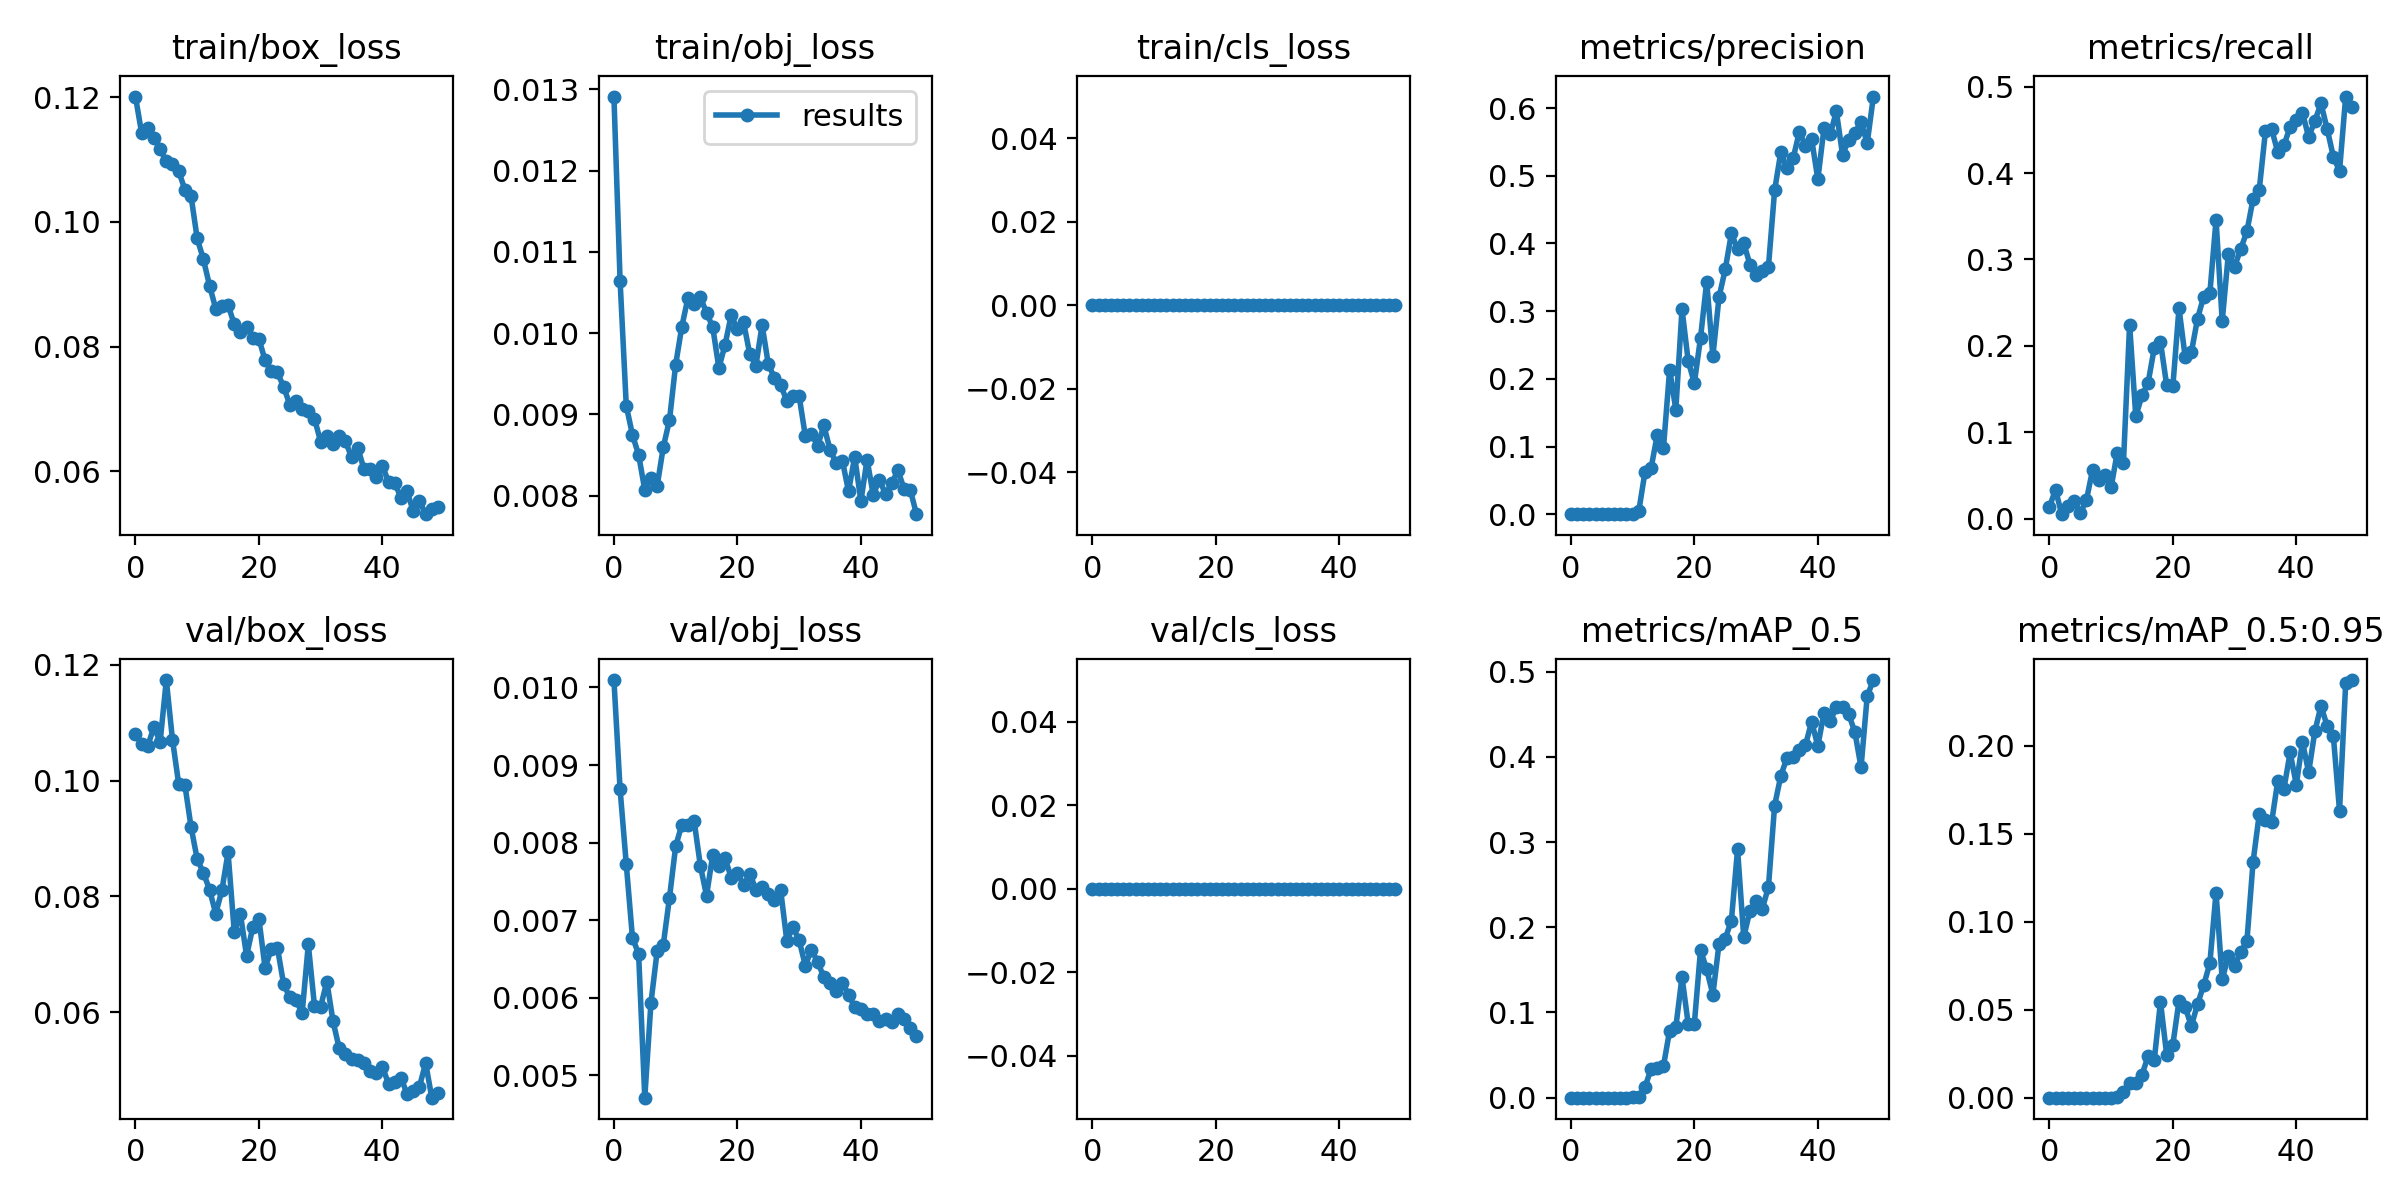

In [55]:
Image.open('runs/train/yolov5s_results3/results.png')

### Test prediction on one image

In [59]:
!python detect.py --weights runs/train/yolov5s_results3/weights/best.pt --img 512 --conf 0.4 --source /app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg

detect: weights=['runs/train/yolov5s_results3/weights/best.pt'], source=/app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg, imgsz=[512, 512], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-43-g19c8760 torch 1.10.0a0+3fd9dcf CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/1 /app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg: 512x512 1 nodule, Done. (0.012s)
Speed: 52.9ms pre-process, 11.7ms inference, 200.7ms NMS per image at shape (1, 3, 512, 512)
Results saved to runs/detect/exp2


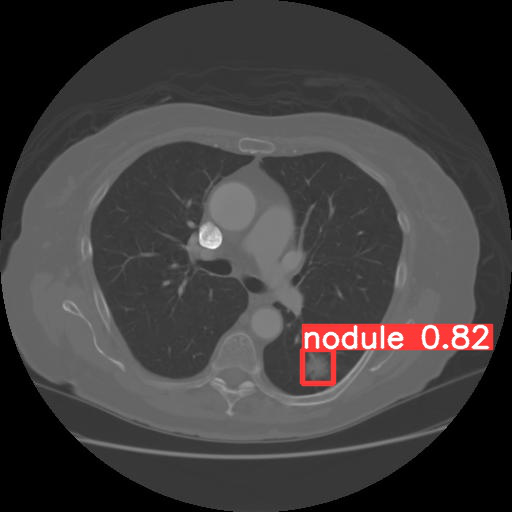

In [60]:
Image.open('runs/detect/exp2/LIDC-IDRI-0001_0_87.jpg')

### Testing

In [61]:
testdir = '/app/yolov5/test'

In [62]:
def removedir(dirname):
    print("Directory {} exists, removing!".format(dirname))
    files = glob.glob(dirname + "/*")
    for i in tqdm(range(len(files))):
        if os.path.isdir(files[i]):
            shutil.rmtree(files[i])
            

def save_patient_image_and_bbox(patient_id, root_dir='/app/yolov5/test'):
    
    # create the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
     
    #clean up any previous data for this patient
    if os.path.exists(patientdir):
        removedir(patientdir)

    print("Creating directory {}".format(imagedirname))
    os.makedirs(imagedirname)

    print("Creating directory {}".format(labeldirname))
    os.makedirs(labeldirname)
            
    # query the image data from the CT volume
    print("Reading data for patient {}".format(patient_id))
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    # save the image, even if it does not have any nodules, this will be used for predictions
    if nodule_num <= 0: # no nodules
        num_slices = vol.shape[2]
        im = vol[:,:,int(num_slices/2)]
        image_filename = "{}_{}.jpg".format(patient_id, int(num_slices/2))
        print("Saving image to file {}".format(imagedirname + "/" + image_filename))
        imageio.imwrite(imagedirname + "/" + image_filename, im)
    else: # when there are nodules present
        for i in range(nodule_num):
            cmask = cmask_CT[i]
            cbbox = cbbox_CT[i]
            masks = masks_CT[i]
            CT_mask[cbbox] += cmask
            img_count = 0
            for k_slice in np.arange(cbbox[2].start, cbbox[2].stop):
                im = vol[:,:,k_slice]    
                msk = CT_mask[:,:,k_slice]
                x,y,w,h = get_bounding_box(msk)
                if x is not None:
                    image_filename = "{}_{}_{}.jpg".format(patient_id, i, k_slice)
                    
                    noduledir = imagedirname + "/" + str(i)
                    if not os.path.exists(noduledir):
                        os.makedirs(noduledir)
                    imageio.imwrite(noduledir + "/" + image_filename, im)
                    c = 0
                    label = "{} {} {} {} {}".format(c, x, y, w, h)
                    label_filename = "{}_{}_{}.txt".format(patient_id, i, k_slice)
                    labeldir = labeldirname + "/" + str(i)
                    if not os.path.exists(labeldir):
                        os.makedirs(labeldir)
                    f = open(labeldir + "/" + label_filename, "a")
                    f.write(label)
                    f.close()
                    img_count += 1
            print("Saved {} images for nodule {} of patient {}".format(img_count, i, patient_id))
    return nodule_num

For a given patient, generate the images for each nodule and the labels

In [63]:
# nodule_num = save_patient_image_and_bbox('LIDC-IDRI-0001', testdir)

In [64]:
model_weights = '/app/yolov5/runs/train/yolov5s_results3/weights/best.pt'

In [627]:
# import re

# source_dir = '/app/yolov5/test/LIDC-IDRI-0001/images/0'
# temp_dir = '/app/yolov5/temp'
# if not os.path.exists(temp_dir):
#     os.makedirs(temp_dir)
# temp_file = temp_dir + "/" + 'temp.txt'
# predict_command = "python detect.py --weights {} --img 512 --conf 0.4 --source {} > {}".format(model_weights, source_dir, temp_file)
# exit_code = os.system(predict_command)

# with open('/app/yolov5/temp/temp.txt') as f:
#     line = f.read()
#     rc = re.compile(r'Results saved to (.*)')
#     m = rc.search(line)
# print("Number of matches is {}".format(len(m.groups())))
# ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
# result = ansi_escape.sub('', m[1])
# print("Saved to path {}".format(result))
# print("Program exited with {}".format(exit_code))

In [65]:
import math
def plot_detections(result_dir='/app/yolov5/runs/detect/exp14'):
    images = os.listdir(result_dir)
    num_images_row = 3
    print("Number of images {}".format(len(images)))
    if len(images) > num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, 3, figsize=(14, 15))
    c = 0
    for idx, img in enumerate(images):
        img = Image.open(result_dir + "/" + img)
        if c > num_images_row-1:
            c = 0
        a[int(idx/num_images_row)][c].imshow(np.array(img))
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

#### Routine to predict nodules

Input: 
- patient id -> enter the patient id
- testdir -> the dir where the images for the patient are extracted an placed
- nodule_num -> the number of nodules as per ground truth in the patient

In [66]:
root_dir = '/app/yolov5'

In [91]:
import re
import subprocess
def predict_nodules(patient_id, testdir, nodule_num, root_dir):
    predicted_paths = []
    for nodule in range(nodule_num):
        source_dir = testdir + "/" + str(patient_id) + "/images/" + str(nodule)
        temp_dir = root_dir + '/temp'
        if not os.path.exists(temp_dir):
            os.makedirs(temp_dir)
        temp_file = temp_dir + "/" + 'temp.txt'
        print("Reading data from {}".format(source_dir))
        predict_command = "python detect.py --weights {} --img 512 --conf 0.25 --source {} 2>&1 | tee {}".format(model_weights, source_dir, temp_file)
        print("Running command:\n")
        print(predict_command)
        ret_code = os.system(predict_command)
        print("Command executed with code {}".format(ret_code))
        print("Scanning output file {}".format(temp_file))
        with open(temp_file) as f:
            line = f.read()
            rc = re.compile(r'Results saved to (.*)')
            m = rc.search(line)
            if (m is not None) and (len(m.groups())>=1):
                ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
                result = ansi_escape.sub('', m[1])
                print("Predicted and saved the results to {}/{}".format('/app/yolov5', result))
            else:
                print("Could not save the predictions!")
            predicted_paths.append(root_dir + "/" + result)
    return predicted_paths

### Test pipeline for a patient

- For a patient id, extract the images and the ground truth bounding box coordinates and save them in one directory, one directory per nodule
- Run the prediction using the bext weights and save the results
- Plot the predictions and compare with the actual images and the ground truth bounding box

In [97]:
testdir = root_dir + '/test/'
patient_id = 'LIDC-IDRI-0001'
nodule_num = save_patient_image_and_bbox(patient_id, testdir)
print("Found {} nodules in patient {}".format(nodule_num, patient_id))
predicted_paths = predict_nodules(patient_id, testdir, nodule_num, root_dir)
print("Found a total of {} nodules".format(len(predicted_paths)))

Directory /app/yolov5/test//LIDC-IDRI-0001 exists, removing!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 777.51it/s]

Creating directory /app/yolov5/test//LIDC-IDRI-0001/images
Creating directory /app/yolov5/test//LIDC-IDRI-0001/labels
Reading data for patient LIDC-IDRI-0001



Lossy conversion from int16 to uint8. Range [-2048, 3038]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2884]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0001 is 1
Saved 8 images for nodule 0 of patient LIDC-IDRI-0001
Found 1 nodules in patient LIDC-IDRI-0001
Reading data from /app/yolov5/test//LIDC-IDRI-0001/images/0
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results3/weights/best.pt --img 512 --conf 0.25 --source /app/yolov5/test//LIDC-IDRI-0001/images/0 2>&1 | tee /app/yolov5/temp/temp.txt
detect: weights=['/app/yolov5/runs/train/yolov5s_results3/weights/best.pt'], source=/app/yolov5/test//LIDC-IDRI-0001/images/0, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-43-g19c8760 torch 1.10.0a0+3fd9dcf CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
M

Number of images 8


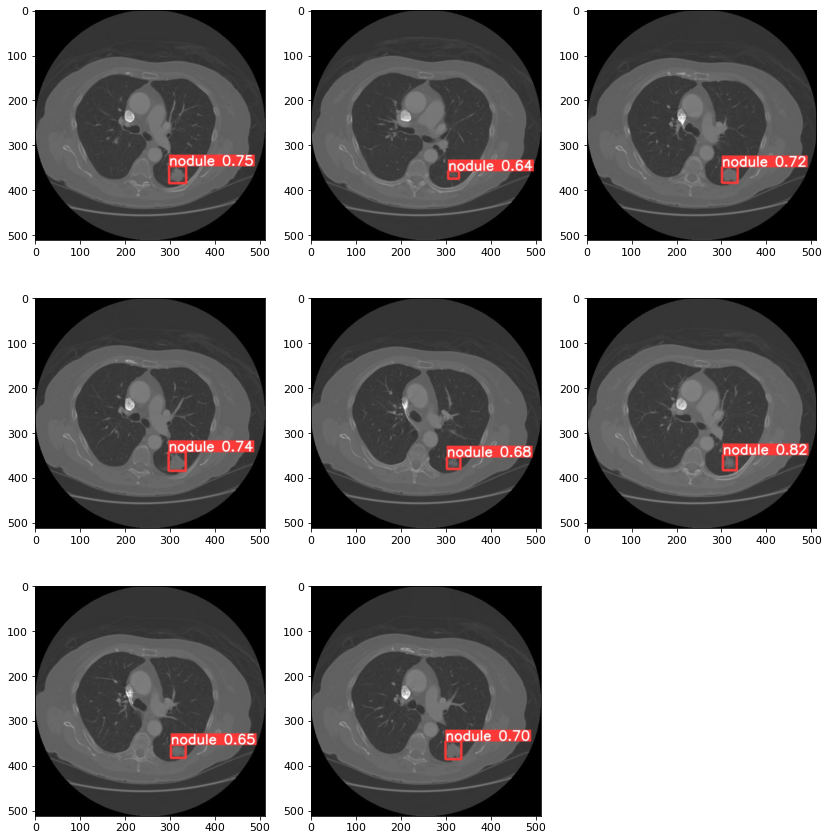

In [98]:
plot_detections(predicted_paths[0])

#### Plot and compare the predicted bounding box vs the actual bounding box

In [99]:
import matplotlib.patches as patches
def plot_and_compare(predicted_paths, patient_id, nodule_num, test_root_dir=testdir):
    
    #get the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = test_root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
    
    
    images = os.listdir(predicted_paths[nodule_num])
    labeldir = labeldirname + "/" + str(nodule_num)
    print("Loading labels from {}".format(labeldir))
    labels = os.listdir(labeldir)
    
    imagedir = imagedirname + "/" + str(nodule_num)
    source_images = os.listdir(imagedir)
    
    num_images_row = 1
    print("Number of images {}".format(len(images)))
    if len(images) > num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, num_images_row*2, figsize=(14, 35))
    c = 0
    for idx, (imgstr, src_imgstr) in enumerate(zip(images, source_images)):
        img = Image.open(predicted_paths[nodule_num] + "/" + imgstr)
        src_img = Image.open(imagedir + "/" + src_imgstr)
        if c > num_images_row-1:
            c = 0
        a[int(idx/num_images_row)][c].imshow(np.array(img))
        a[int(idx/num_images_row)][c+1].imshow(np.array(src_img))
        src_labelstr = src_imgstr.replace('.jpg','.txt')
        
        with open(labeldir + "/" + src_labelstr) as f:
            line = f.read()
            cls, x, y, w, h = line.split(' ')
            x, y, w, h = float(x), float(y), float(w), float(h)
            rect = patches.Rectangle((x, y), (w), (h), linewidth=1, edgecolor='r', facecolor='none')
            a[int(idx/num_images_row)][c+1].add_patch(rect)
            
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

Loading labels from /app/yolov5/test/LIDC-IDRI-0001/labels/0
Number of images 8


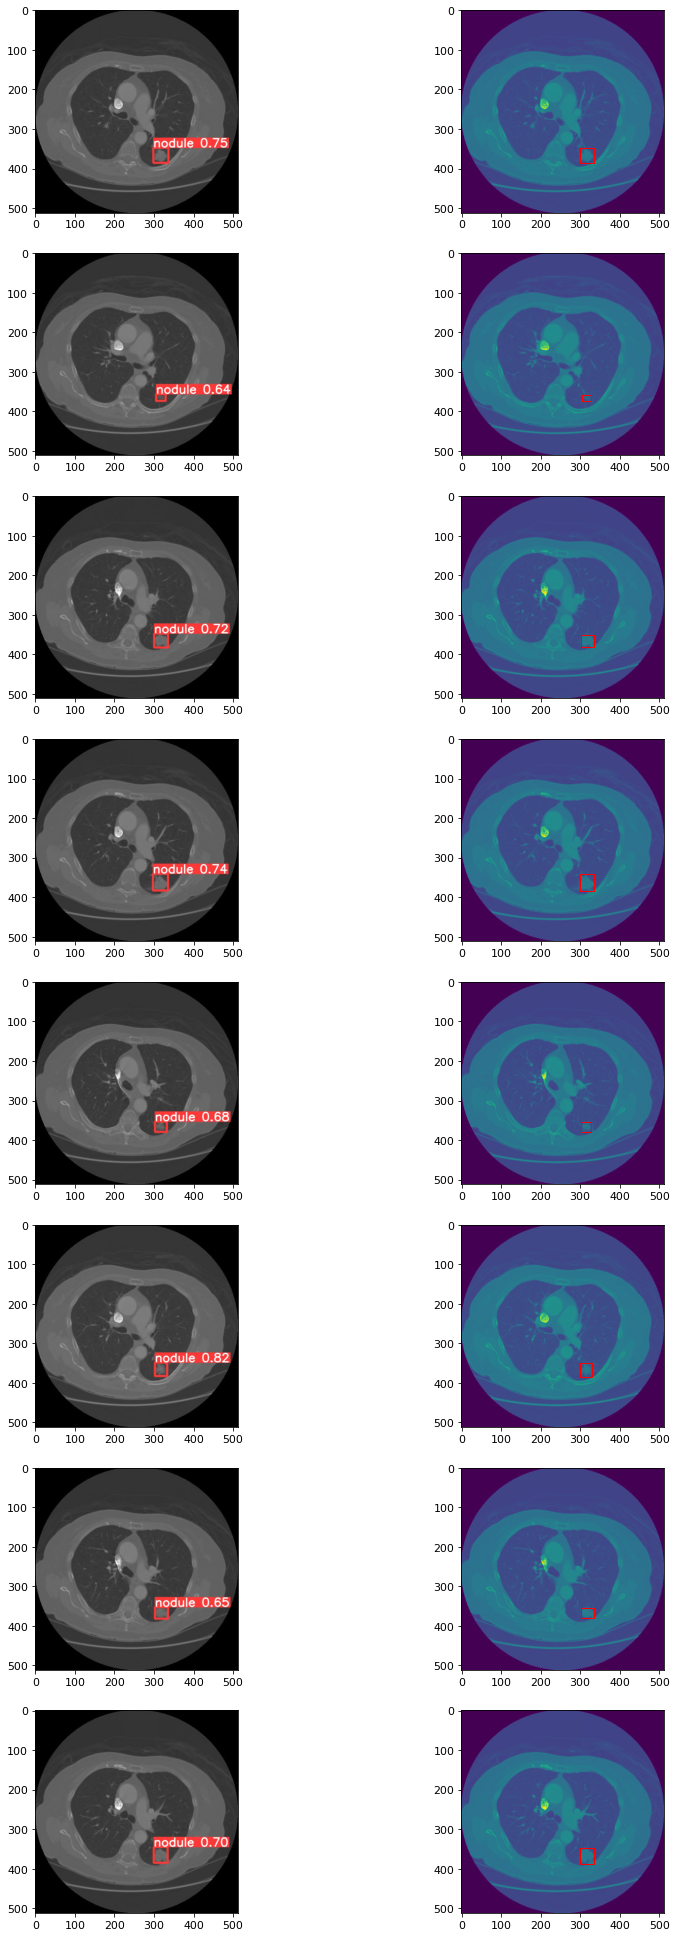

In [100]:
plot_and_compare(predicted_paths, 'LIDC-IDRI-0001', 0, '/app/yolov5/test')

### Load the saved segmentation model

In [101]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.parallel import DistributedDataParallel as DDP

In [102]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs
    


class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(512,512)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [118]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 1


In [122]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()

In [123]:
seg_model.load_state_dict(torch.load('/app/saved_model/Epoch24.pth'))
seg_model.eval()

DataParallel(
  (module): Unet(
    (encoder): Encoder(
      (enc_blocks): ModuleList(
        (0): Block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu1): ReLU()
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu2): ReLU()
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Block(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu1): ReLU()
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu2): ReLU()
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Block(
 

In [124]:
summary(seg_model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
             Block-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14         [-1, 64, 2

In [125]:
predicted_paths

['/app/yolov5/runs/detect/exp10']

In [127]:
nodule_num = 0
test_root_dir = '/app/yolov5/test/'
imagedirname = None
dirname = patient_id#.replace('-','_')
patientdir = test_root_dir + "/" + dirname
imagedirname = patientdir + "/" + 'images'
images = os.listdir(predicted_paths[nodule_num])
imagedir = imagedirname + "/" + str(nodule_num)
source_images = os.listdir(imagedir)
source_images

['LIDC-IDRI-0001_0_88.jpg',
 'LIDC-IDRI-0001_0_86.jpg',
 'LIDC-IDRI-0001_0_91.jpg',
 'LIDC-IDRI-0001_0_89.jpg',
 'LIDC-IDRI-0001_0_93.jpg',
 'LIDC-IDRI-0001_0_87.jpg',
 'LIDC-IDRI-0001_0_92.jpg',
 'LIDC-IDRI-0001_0_90.jpg']

In [ ]:
nodule_num = 0
imagedirname = None
dirname = patient_id#.replace('-','_')
patientdir = test_root_dir + "/" + dirname
imagedirname = patientdir + "/" + 'images'
images = os.listdir(predicted_paths[nodule_num])
imagedir = imagedirname + "/" + str(nodule_num)
source_images = os.listdir(imagedir)
 

#image = vol[:,:,k_slice].astype('float32')
Image.open()
image -= np.mean(image)

image /= np.std(image)
image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
mask_pre = np.squeeze(mask_pre)
#  print(np.max(mask_pre), np.min(mask_pre))
#  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
mask_pre = np.where(mask_pre>0.5, 1,0)

## Backup

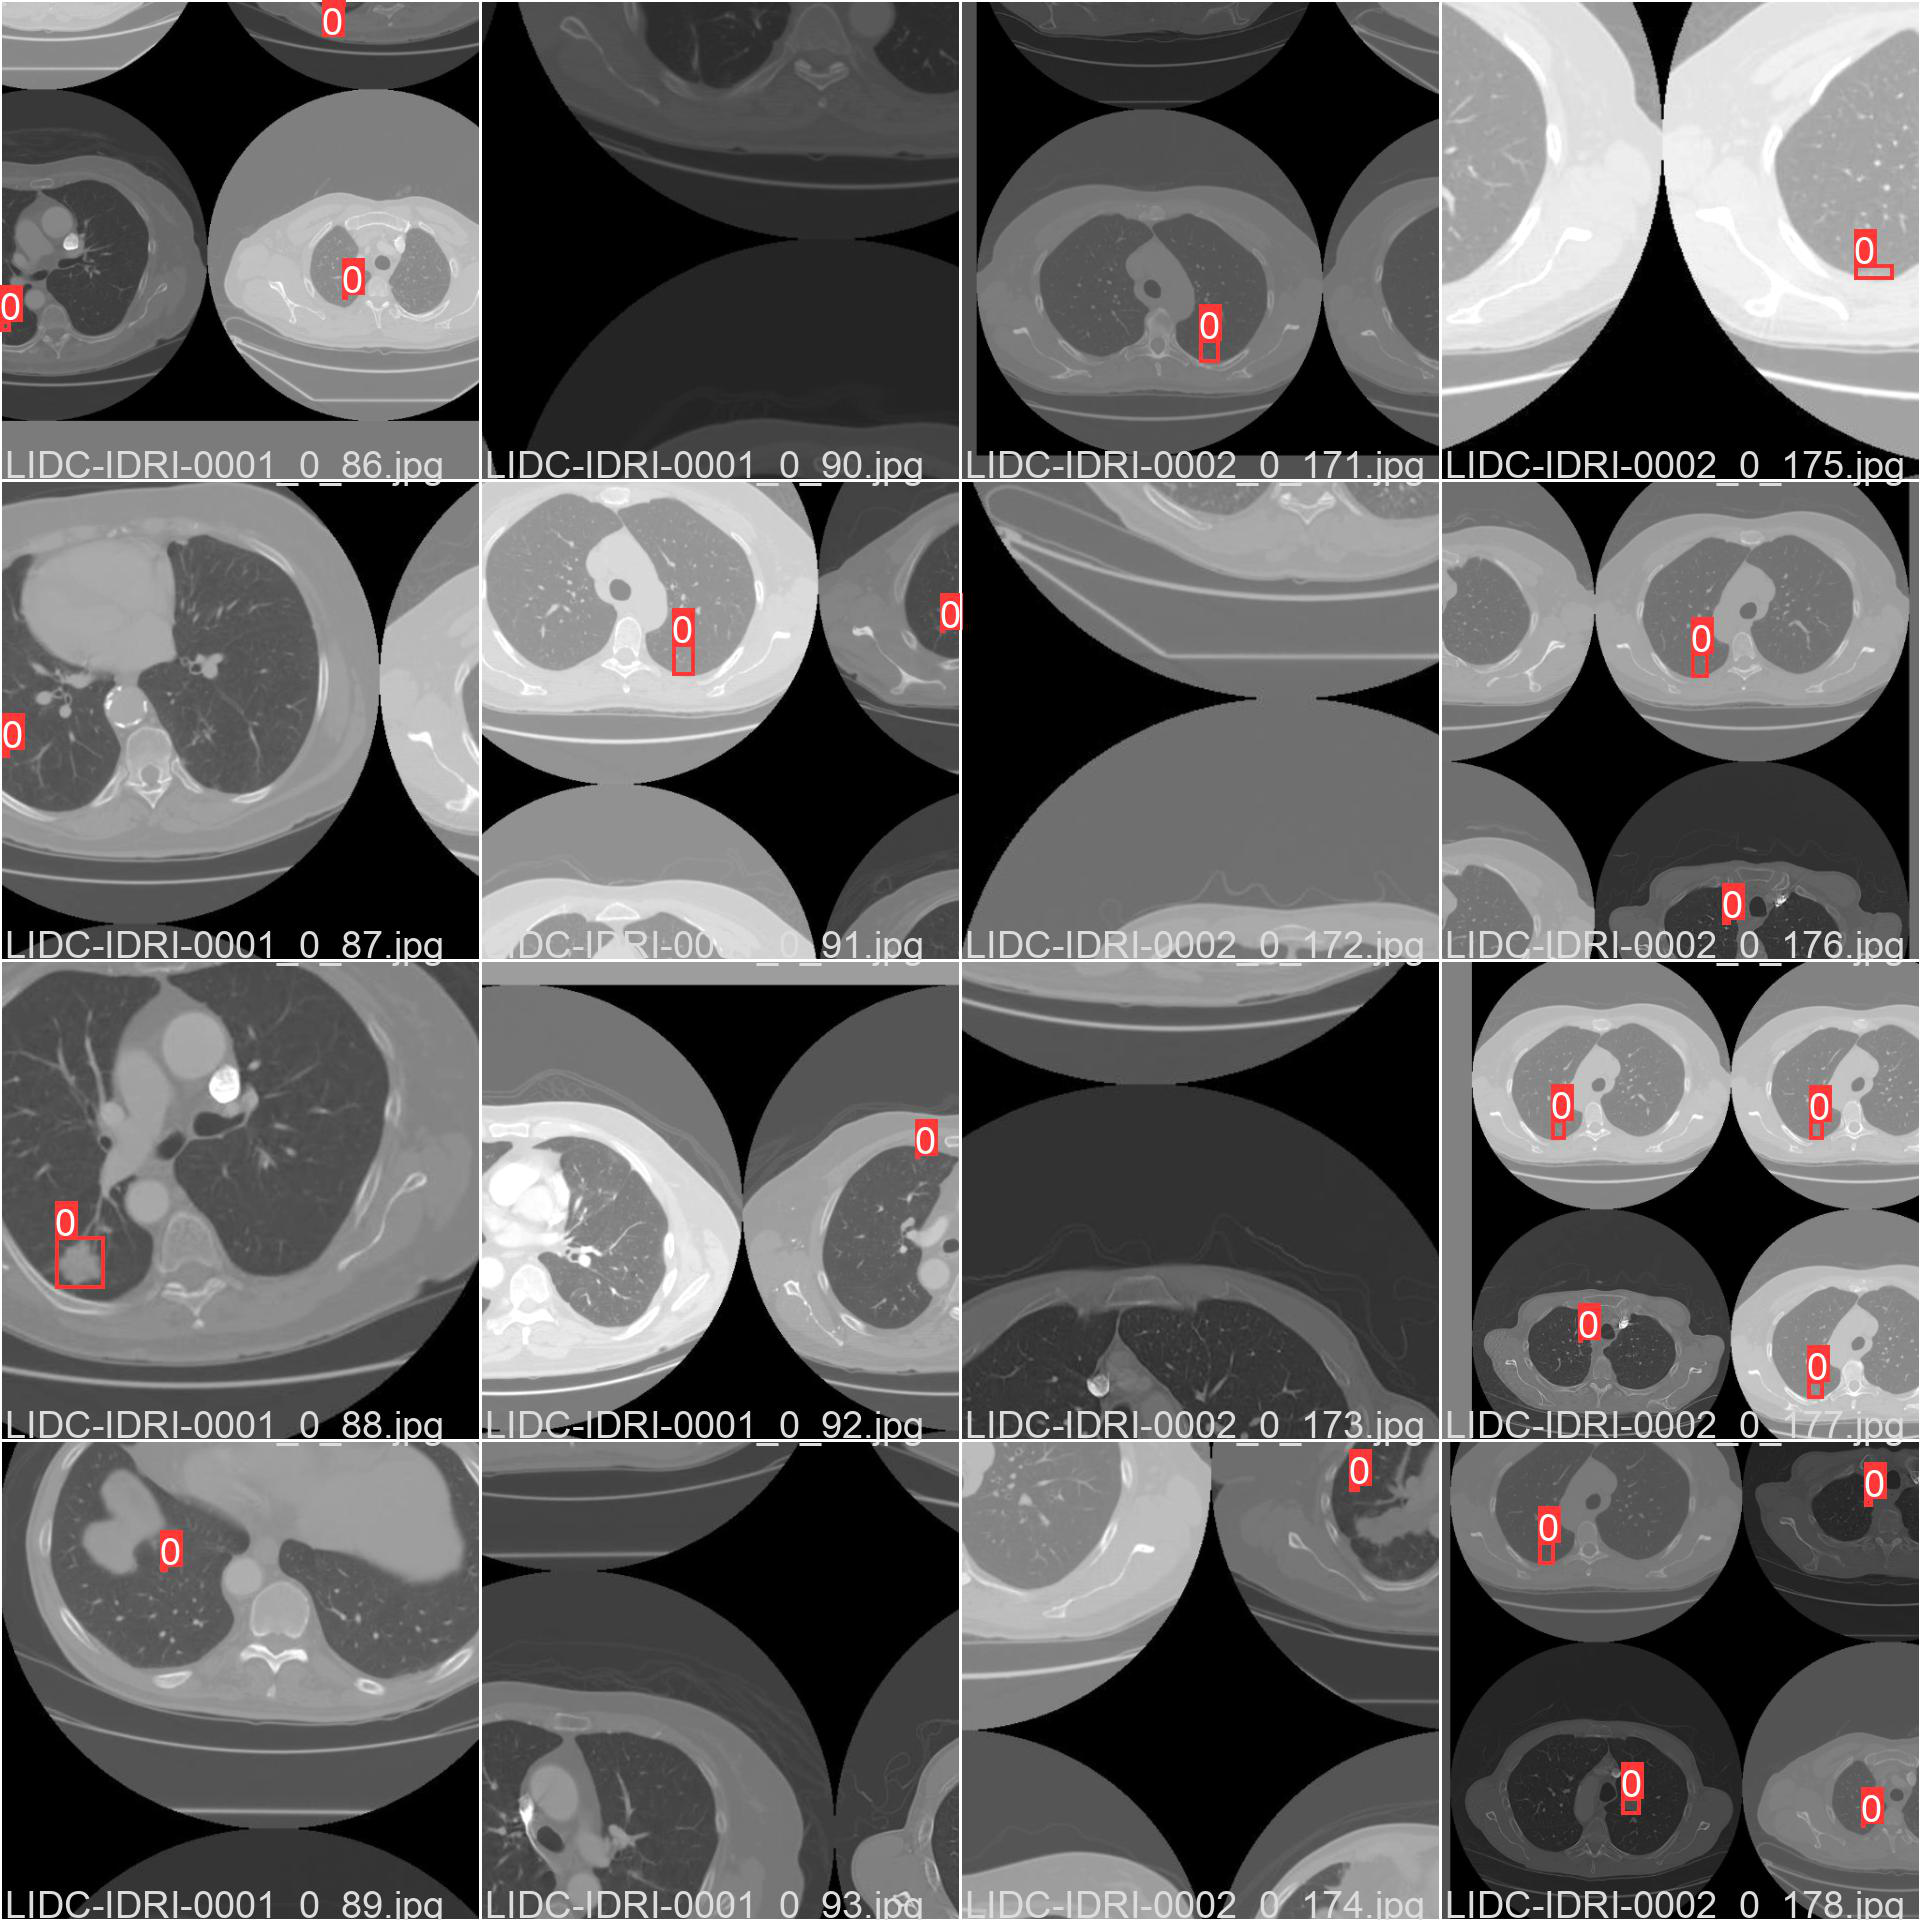

In [165]:
Image.open('runs/train/yolov5s_results2/train_batch0.jpg')

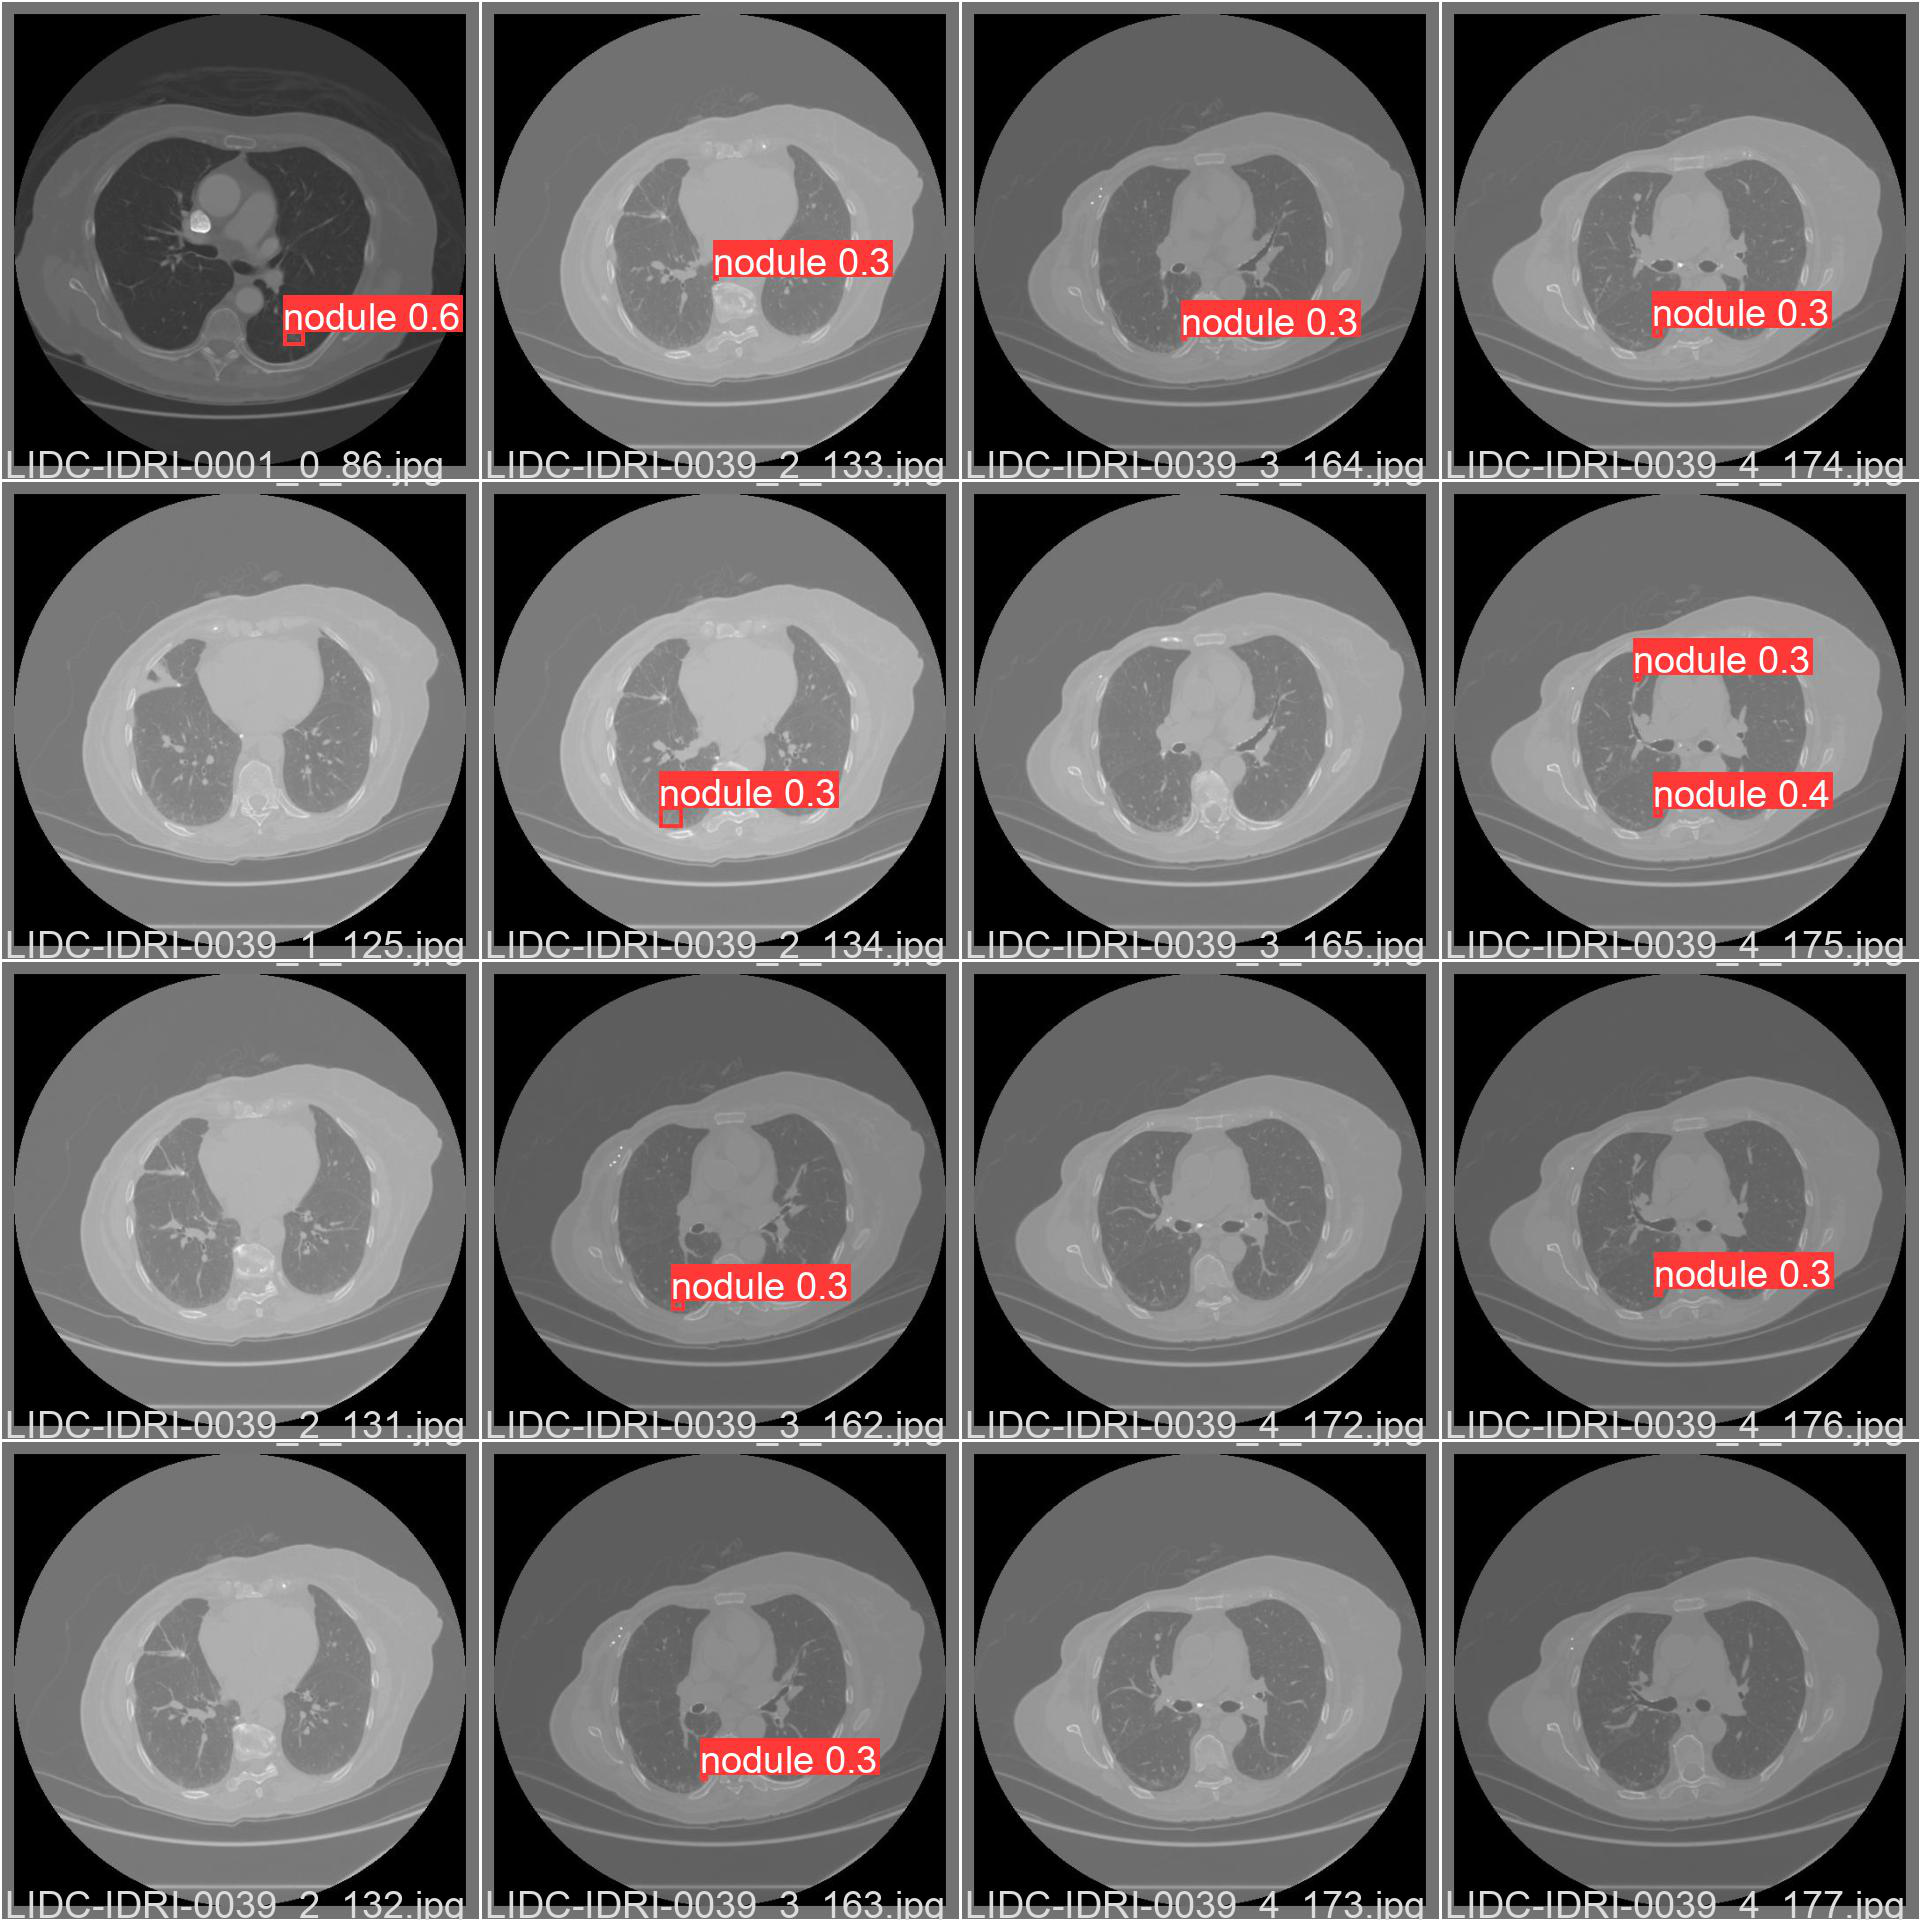

In [342]:
Image.open('runs/train/yolov5s_results3/val_batch0_pred.jpg')

In [212]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0008_0_70.txt

0 0.228515625 0.5732421875 0.033203125 0.01953125

In [12]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0001_0_90.txt

0 0.630859375 0.70703125 0.0859375 0.1015625

In [16]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0001_0_86.txt

0 0.630859375 0.70703125 0.0859375 0.1015625

In [199]:
#!apt-get update

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]                
Get:3 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [801 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1183 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [30.1 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [628 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:12 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:13 http://archive.ubuntu

In [201]:
#!apt-get install ffmpeg libsm6 libxext6  -y

In [25]:
!cat /app/roboflow/train/labels/LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.txt

0 0.6274038461538461 0.7175480769230769 0.09615384615384616 0.09134615384615384

In [21]:
ls /app/roboflow/train/images/

LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.jpg


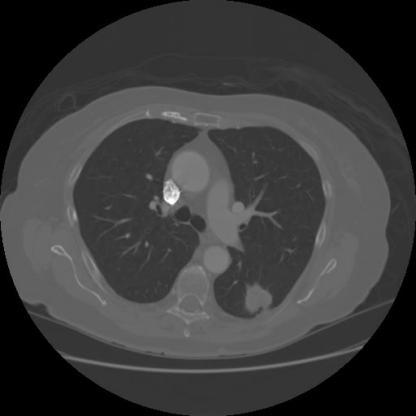

In [22]:
Image.open('/app/roboflow/train/images/LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.jpg')

In [53]:
ls /app/yolov5/runs/train/yolov5s_results23

confusion_matrix.png                                test_batch0_pred.jpg
events.out.tfevents.1635700289.e9ea4f0c832f.3518.0  test_batch1_labels.jpg
hyp.yaml                                            test_batch1_pred.jpg
labels.jpg                                          test_batch2_labels.jpg
labels_correlogram.jpg                              test_batch2_pred.jpg
opt.yaml                                            train_batch0.jpg
results.png                                         train_batch1.jpg
results.txt                                         train_batch2.jpg
test_batch0_labels.jpg                              weights/


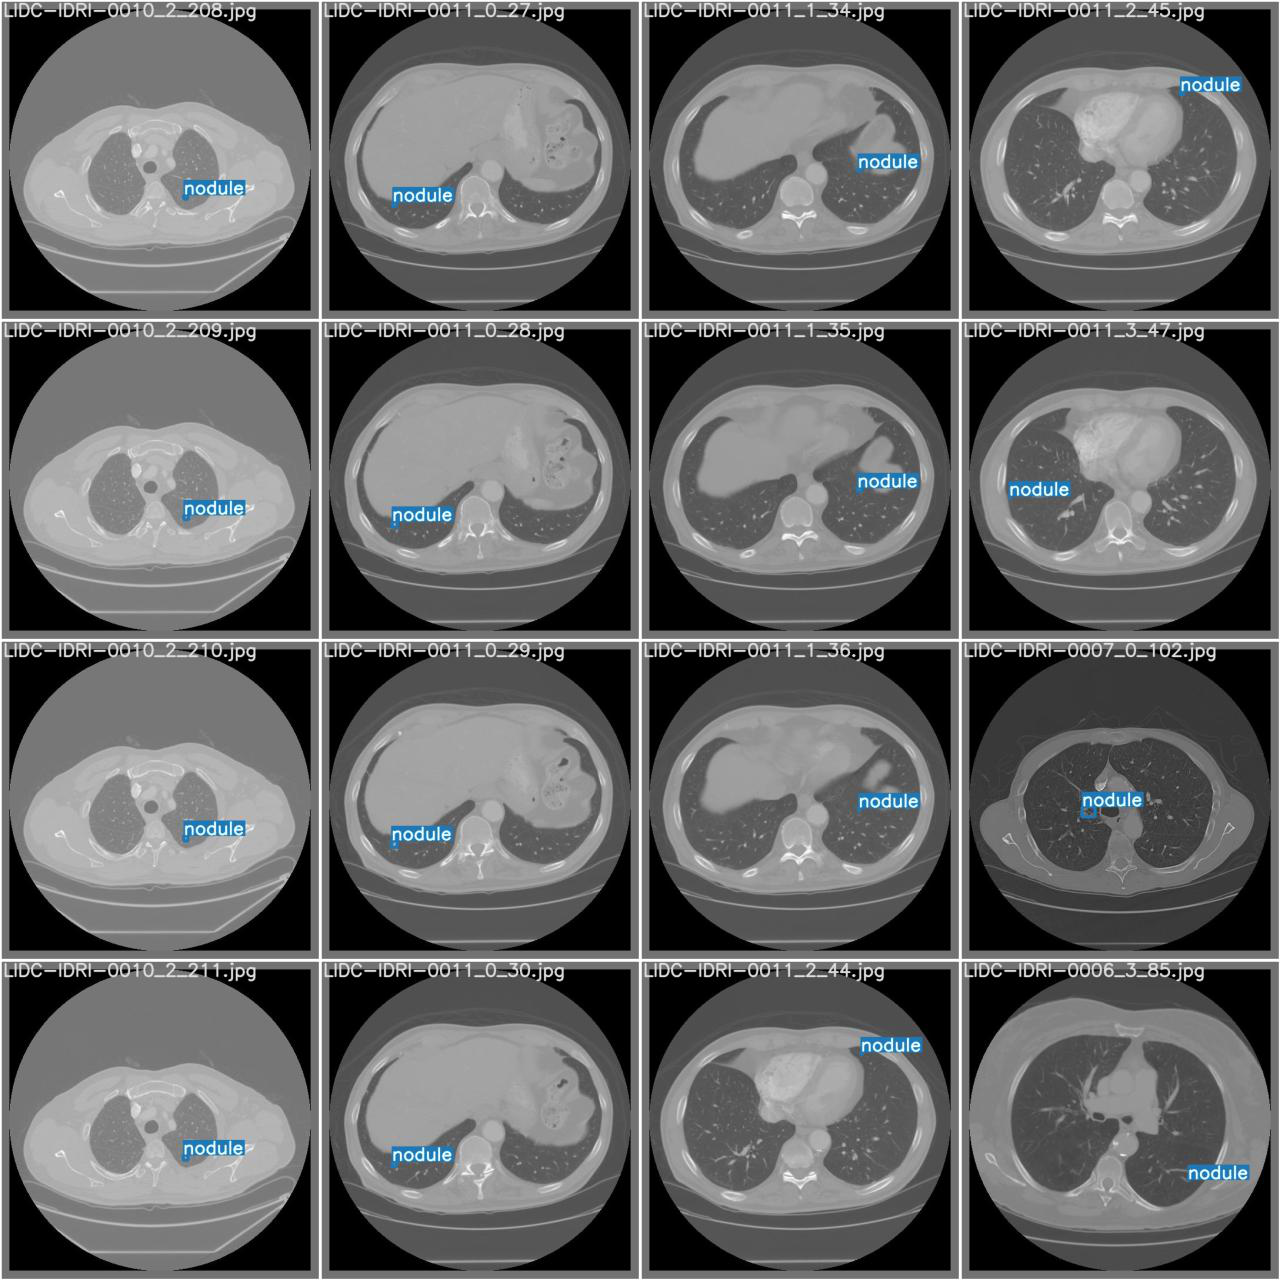

In [54]:
Image.open('/app/yolov5/runs/train/yolov5s_results23/test_batch2_labels.jpg')

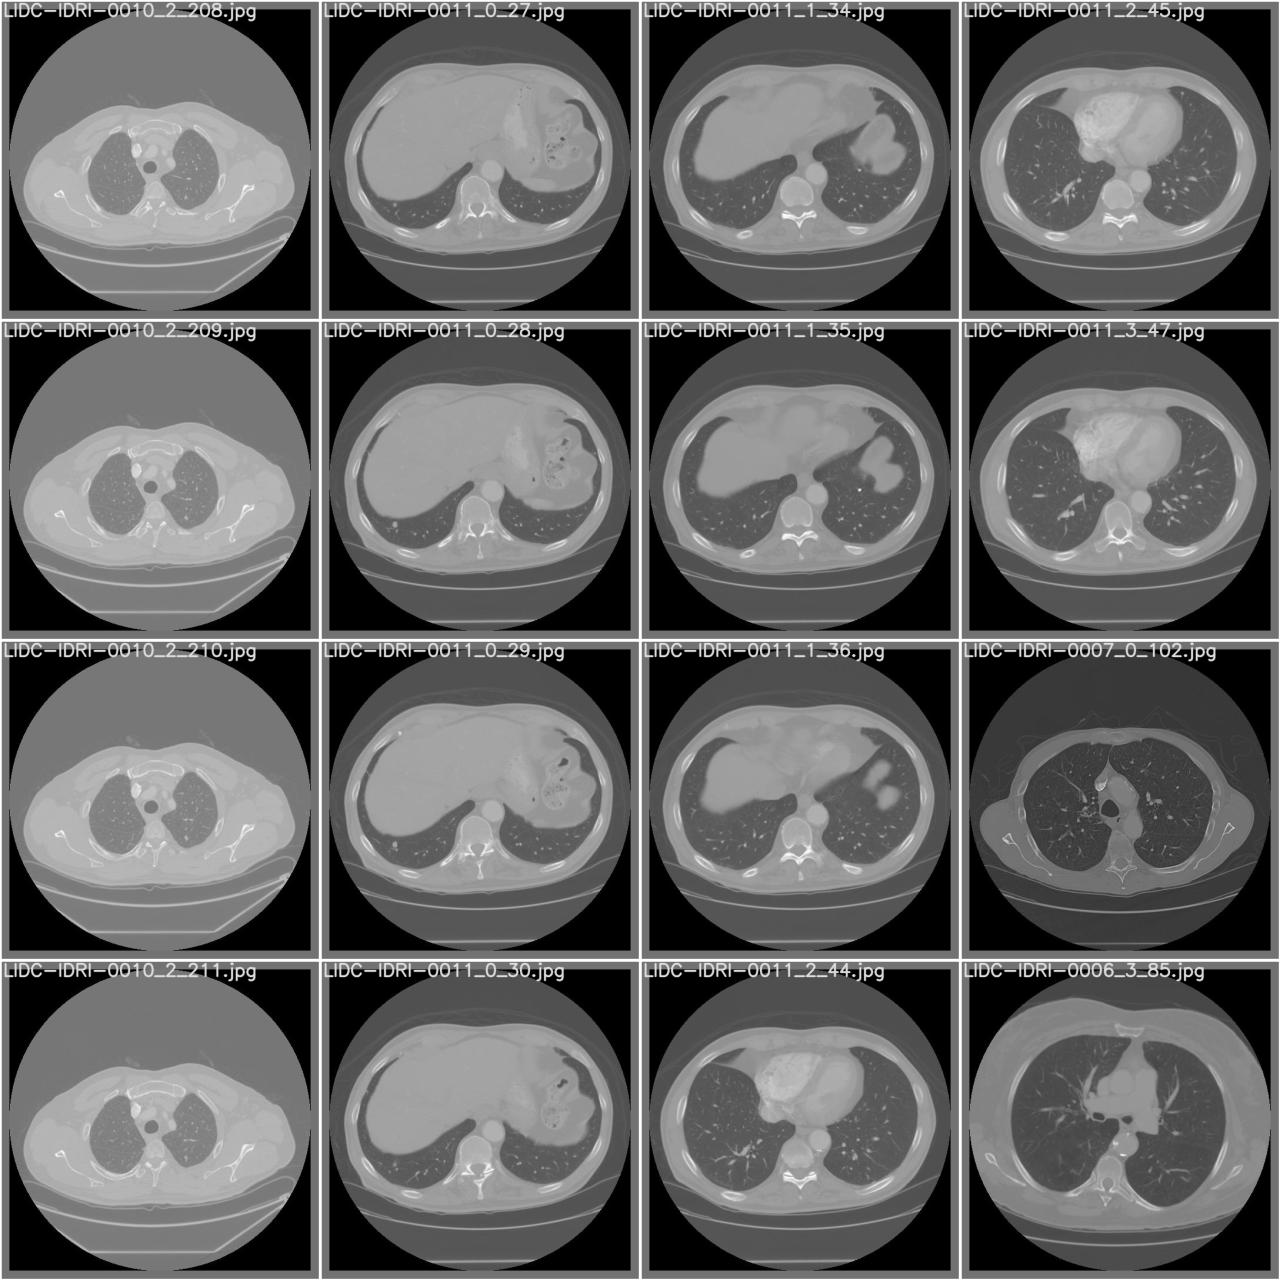

In [55]:
Image.open('/app/yolov5/runs/train/yolov5s_results23/test_batch2_pred.jpg')

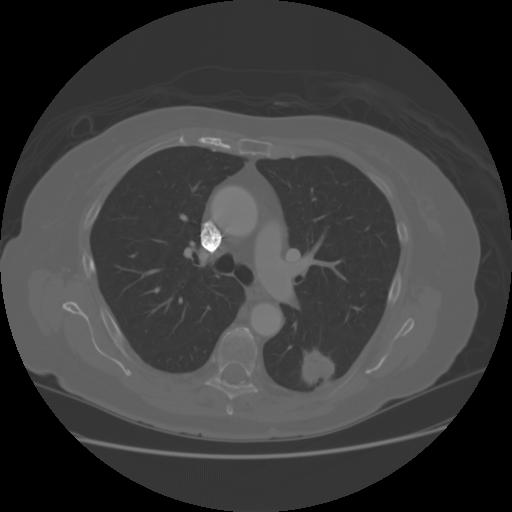

In [11]:
Image.open('/app/data/yolov5/train/images/LIDC-IDRI-0001_0_90.jpg')

In [143]:
ls /app/data/yolov5/train/images

LIDC-IDRI-0001_0_86.jpg   LIDC-IDRI-0003_2_84.jpg   LIDC-IDRI-0008_1_87.jpg
LIDC-IDRI-0001_0_87.jpg   LIDC-IDRI-0003_3_81.jpg   LIDC-IDRI-0008_1_88.jpg
LIDC-IDRI-0001_0_88.jpg   LIDC-IDRI-0003_3_82.jpg   LIDC-IDRI-0008_1_89.jpg
LIDC-IDRI-0001_0_89.jpg   LIDC-IDRI-0003_3_83.jpg   LIDC-IDRI-0009_0_102.jpg
LIDC-IDRI-0001_0_90.jpg   LIDC-IDRI-0003_3_84.jpg   LIDC-IDRI-0009_0_103.jpg
LIDC-IDRI-0001_0_91.jpg   LIDC-IDRI-0003_3_85.jpg   LIDC-IDRI-0009_0_104.jpg
LIDC-IDRI-0001_0_92.jpg   LIDC-IDRI-0003_3_86.jpg   LIDC-IDRI-0009_1_165.jpg
LIDC-IDRI-0001_0_93.jpg   LIDC-IDRI-0003_3_87.jpg   LIDC-IDRI-0009_1_166.jpg
LIDC-IDRI-0001_0_94.jpg   LIDC-IDRI-0003_3_88.jpg   LIDC-IDRI-0009_1_167.jpg
LIDC-IDRI-0002_0_171.jpg  LIDC-IDRI-0004_0_74.jpg   LIDC-IDRI-0009_1_168.jpg
LIDC-IDRI-0002_0_172.jpg  LIDC-IDRI-0004_0_75.jpg   LIDC-IDRI-0010_0_67.jpg
LIDC-IDRI-0002_0_173.jpg  LIDC-IDRI-0004_0_76.jpg   LIDC-IDRI-0010_0_68.jpg
LIDC-IDRI-0002_0_174.jpg  LIDC-IDRI-0004_0_77.jpg   LIDC-IDRI-0010_0_69.jpg
LIDC-

Loading dicom files ... This may take a moment.


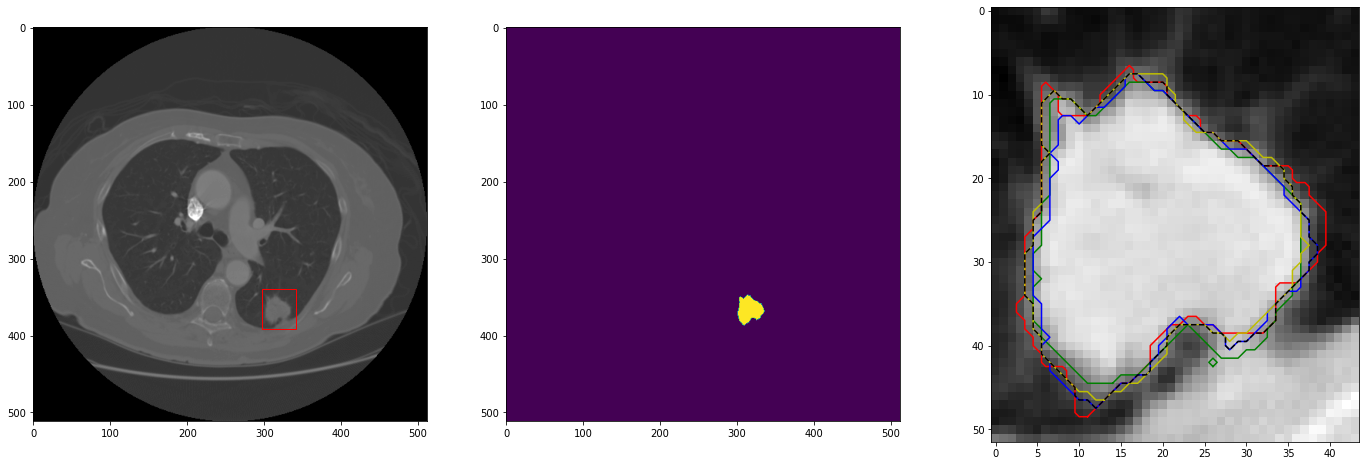

In [227]:
%matplotlib inline
import matplotlib.patches as patches
patient_select = 0
cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

#print ("Current patient ID =", patient_list[patient_select])
patient_list = ['LIDC-IDRI-0001']
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    ax = plt.subplot(nodule_num,3,1+i*3)
    im1 = vol[:,:,k_slice]
    #im1 = Image.fromarray(im1)
    #im1 = im1.transpose(Image.FLIP_TOP_BOTTOM)
    #im1 = np.flip(im1, 0)
    #PIL.Image.FLIP_TOP_BOTTOM
    plt.imshow(im1,cmap='gray')
    #plt.clim(vmin=-1350,vmax=-150)
    
    x,y,z = cbbox
    rect = patches.Rectangle((y.start, x.start), (y.stop-y.start), (x.stop-x.start), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')